#**CIS 545 Final Project**

**Group Members :** Ajay Anand, Jiong Chen, Jiayu Li

**Data Sources:** “Airbnb Price New York City” from Kaggle.com. The “Airbnb Price New York” dataset contains information regarding rentals around the New York city area. The data contains the basic information regarding the rentals, the basic information, tiers, and reviews regarding the hosts, and also corresponding pricing information. The dataset was introduced and shared by Jiayu Li’s friend from Columbia University.

**Study Aim:** The project aims to study the correlation between the rental sales price with variables including but limited to host tiers, location, rental types and dimensions, beds types, and the sales (listing) price of the rental on Airbnb, which is a large rental marketspace operating worldwide. After that, our group aims to predict the list price using different machine learning models and apply a proper neural network model which will be referenced by hosts and potential renters for specific properties.

**Ultimate Objective:** The ultimate objective of this project is to testify and predict the proper price for a specific rental, which can benefit both the hosts and potential renters. Both regression for price prediction and classification regarding below or above average has been conducted in this proejct. Our group hopes to help the hosts to understand proper range for their properties and adjust their listing price accordingly to increase reservation rate. Also, our group also hopes to use the models and results to help potential renters to understand the listing price for a specific property they are interested in.

This blog post explains the background of post but uses a different dataset:https://towardsdatascience.com/predicting-airbnb-prices-with-machine-learning-and-deep-learning-f46d44afb8a6

# **PART I Data Processing and Visualization**

##**1. Loading the Airbnb Data**

We will download our airbnb data from the kaggle website using the json token provided in our submission folder. After zipping the compressed airbnb-new-york.zip file, we will get a csv file named airbnb.csv. This file will serve as a major source for data in the analysis for this proejct. In addition, we also provided the geographic mapping containing four files, which all nemaed MODZCTA_2010 with format .dbf, .prj, .shp, and .shx. Only by importing those four files at the same time, we will be able to load the shp file into the colab. 

In [2]:
#Package Install and Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
from collections import Counter
from wordcloud import WordCloud


In [3]:
#Using Kaggle to Load the dataset
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jiayl66/airbnb-new-york
!unzip /content/airbnb-new-york.zip

cp: cannot stat 'kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open /content/airbnb-new-york.zip, /content/airbnb-new-york.zip.zip or /content/airbnb-new-york.zip.ZIP.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# read data
# airbnb_df = pd.read_csv('airbnb.csv')
airbnb_df = pd.read_csv('/content/drive/Shareddrives/CIS545 Final Project/airbnb.csv')
airbnb_for_word = airbnb_df.copy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (31,79,80) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


##**2. Handling Missing Value**
The first thing we will have to do is to check the missing values in our dataset. By counting the number of missing values in each of the feature and divided by the column's overall entry number, we created a dataframe containing each feature's name and its corresponding missing percentage. In this part, we will directly drop those features that contains more than 50 percent of missing data because it would be hard and unnecessary to impute such large proportion of data. In the following step, we will also do some further imputation for those missing data with relatively smaller proportion. 

In [6]:
# check missing value
percent_missing = airbnb_df.isnull().sum() * 100 / len(airbnb_df)
missing_value_df = pd.DataFrame({'column_name': airbnb_df.columns,'percent_missing': percent_missing})
missing_value_df = missing_value_df.sort_values('percent_missing')
# drop columns with percent missing larger than 50%
drop_list = missing_value_df[missing_value_df['percent_missing'] > 50]['column_name'].to_list()
missing_value_df

,column_name,percent_missing
id,id,0.000000
state,state,0.000000
has_availability,has_availability,0.000000
calendar_updated,calendar_updated,0.000000
smart_location,smart_location,0.000000
...,...,...
weekly_price,weekly_price,92.322768
square_feet,square_feet,99.133801
monthly_price,monthly_price,99.506412
jurisdiction_names,jurisdiction_names,99.961287


In [7]:
# drop the features with missing percentage larger than 50% using the drop list created above
airbnb_df = airbnb_df.drop(drop_list, axis = 1)

In [8]:
#show the information of the dataset after dropping missing value
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41330 entries, 0 to 41329
Data columns (total 85 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            41330 non-null  int64  
 1   name                                          41330 non-null  object 
 2   summary                                       39629 non-null  object 
 3   space                                         31531 non-null  object 
 4   description                                   40657 non-null  object 
 5   neighborhood_overview                         28816 non-null  object 
 6   transit                                       29211 non-null  object 
 7   access                                        24256 non-null  object 
 8   interaction                                   26569 non-null  object 
 9   house_rules                                   26697 non-null 

##**3. Data Wrangling and Encoding**

Our group aims to use the features that are publicly avaiable to both the hosts and the renters in order to better estimate the price for the Airbnb room and its corresponding price range (below or above average Airbnb listing price in NYC). Therefore, uncessary data to the training such as "id" and "name", repeated data by visual examination such as "city", "state", "country", same for all the instances as this is an NYC dataset, and data for Airbnb Internal use, such as "host_about", "neighbourhood_group_cleansed" are dropped. Also,in order to minimize the bias and increase the performance of the model, features like "descriptions", "summary", "first_review", and "last view" are also dropped in this case since we will not be able to verify the accuracy of review, which may has the potential to significantly affect the price.

In [9]:
#list of the feature that will be dropped by visual inspection using the general rules introduced above
drop_feature = ['id','name','description','summary', 'space','neighborhood_overview', 'transit', 'access', 'interaction','house_rules', 'host_name', 
                       'host_location', 'host_about', 'host_neighbourhood', 'host_verifications', 'street', 'neighbourhood', 'neighbourhood_cleansed',
                       'neighbourhood_group_cleansed','city', 'state', 'market', 'smart_location', 'country_code', 'country','calendar_updated','first_review','last_review',
                       'calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
                       'calculated_host_listings_count_shared_rooms','maximum_nights_avg_ntm','maximum_minimum_nights',
                       'minimum_nights_avg_ntm','minimum_maximum_nights','maximum_maximum_nights','minimum_minimum_nights','property_type']

In [10]:
airbnb_df = airbnb_df.drop(drop_feature, axis = 1)

In [11]:
#list of the numerical features that does not require encoding and processing
airbnb_ready = ['cleaning_fee', 'guests_included', 'availability_30', 'review_scores_checkin','maximum_nights', 'minimum_nights', 'availability_60', 'extra_people', 'availability_365', 'host_total_listings_count',
                'availability_90', 'number_of_reviews', 'accommodates', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness','host_listings_count', 
                'security_deposit', 'review_scores_value', 'review_scores_communication', 'bathrooms','review_scores_location', 'number_of_reviews_ltm', 'price', 'bedrooms', 'beds']

In [12]:
#get the list of the features that require encoding and processing
airbnb_needs_processing = list(set(airbnb_df.columns) - set(airbnb_ready))

In [13]:
airbnb_df[airbnb_needs_processing]

,host_acceptance_rate,room_type,requires_license,is_location_exact,reviews_per_month,host_has_profile_pic,require_guest_phone_verification,host_since,host_response_time,host_identity_verified,host_response_rate,cancellation_policy,has_availability,is_business_travel_ready,bed_type,require_guest_profile_picture,amenities,instant_bookable,zipcode,host_is_superhost
0,NaN,Entire home/apt,f,t,2.00,t,f,2019-06-13,within a few hours,f,70%,strict_14_with_grace_period,t,f,Real Bed,f,"TV,Wifi, Air conditioning ,Kitchen,Heating,Was...",f,11207,f
1,25%,Entire home/apt,f,f,0.14,t,f,2011-06-08,within an hour,t,86%,strict_14_with_grace_period,t,f,Real Bed,f,"TV,Internet,Wifi,Kitchen, Pets live on this pr...",f,11238,f
2,66%,Entire home/apt,f,t,3.72,t,f,2013-01-20,within a day,f,100%,strict_14_with_grace_period,t,f,Real Bed,f,"TV,Wifi, Air conditioning ,Kitchen,Heating,Was...",f,11238,t
3,98%,Private room,f,t,1.35,t,f,2014-08-18,within an hour,t,100%,strict_14_with_grace_period,t,f,Real Bed,f,"Wifi, Air conditioning ,Kitchen, Buzzer/wirele...",f,10018,f
4,100%,Private room,f,t,1.34,t,f,2018-09-14,within an hour,f,100%,strict_14_with_grace_period,t,f,Real Bed,f,"Wifi, Air conditioning ,Kitchen, Free street p...",t,11104,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41325,70%,Entire home/apt,f,t,1.57,t,f,2010-03-15,within a few hours,t,100%,moderate,t,f,Real Bed,f,"Wifi, Air conditioning ,Kitchen, Free street p...",f,11205.0,f
41326,NaN,Entire home/apt,f,t,3.38,t,f,2015-05-28,within an hour,t,100%,strict_14_with_grace_period,t,f,Real Bed,f,"TV,Internet,Wifi, Air conditioning ,Kitchen, P...",t,10014.0,f
41327,100%,Private room,f,f,0.41,t,f,2015-08-16,within an hour,f,100%,strict_14_with_grace_period,t,f,Real Bed,f,"TV,Wifi, Air conditioning ,Kitchen,Elevator,He...",f,10037.0,f
41328,100%,Private room,f,t,3.84,t,f,2017-04-15,within an hour,t,93%,flexible,t,f,Real Bed,f,"Wifi, Air conditioning ,Kitchen, Pets allowed ...",t,10009.0,f


Our group decided to use both the Label Encoding and One-Hot Encoding for our datasets. The general rules are applying Label Encoding to all the boolean based features (t/f) and using One-Hot Encoding for categorical features will no more than 8 features. Specifical treatment has been conducted for the "amenities" features as both the Label Encoding and One-Hot Encoding are not appropriate due to large amount of features included. The performance of the model is not ideal even applying sparse data structure. Therefore, our group decided to count the total number of amenities each instance provided and use this form for training the model. Normal Data Wrangling and Data Imputation are also performed in this section.

In [14]:
#import LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [15]:
#Using label encoding to encode all the selected boolean features
airbnb_df['host_identity_verified'] = le.fit_transform(airbnb_df['host_identity_verified'])
airbnb_df['is_business_travel_ready'] = le.fit_transform(airbnb_df['is_business_travel_ready'])
airbnb_df['is_location_exact'] = le.fit_transform(airbnb_df['is_location_exact'])
airbnb_df['host_is_superhost']= le.fit_transform(airbnb_df['host_is_superhost'])
airbnb_df['host_has_profile_pic'] = le.fit_transform(airbnb_df['host_has_profile_pic'])
airbnb_df['requires_license'] = le.fit_transform(airbnb_df['requires_license'])
airbnb_df['instant_bookable'] = le.fit_transform(airbnb_df['instant_bookable'])
airbnb_df['has_availability'] = le.fit_transform(airbnb_df['has_availability'])
airbnb_df['require_guest_profile_picture'] = le.fit_transform(airbnb_df['require_guest_profile_picture'])
airbnb_df['require_guest_phone_verification'] = le.fit_transform(airbnb_df['require_guest_phone_verification'])

In [16]:
from dataclasses import replace
# Based on the rules published by Airbnb, it will only shows the response time within a day or over a day on the website, which customer avaible to the cusomter.
# Therefore, our group decide to set all the response rate less or equal to 24 hours to True, or 1, while the others to False, or 0

airbnb_df['host_response_time'] = airbnb_df['host_response_time'].replace(['within a few hours', 'within an hour', 'within a day'],1)
airbnb_df.loc[airbnb_df['host_response_time'] != 1, 'host_response_time'] = 0
airbnb_df['host_response_time'] = airbnb_df['host_response_time'] .astype(str).astype(int)

In [17]:
#convert the "host_response_rate" to float and based on the rules published by Airbnb, when the host are new to the platform, their response rate will be NA.
#Therefore, all the NA will be set to 0 in this case pertinent to Airbnb rules.
airbnb_df['host_response_rate'] = airbnb_df['host_response_rate'].str.rstrip('%').astype('float') / 100.0
airbnb_df.loc[airbnb_df['host_response_rate'].isna(), 'host_response_rate'] = 0

In [18]:
#One the Year of start will be kept and take into account as this will be the information available to the pubic.
airbnb_df = airbnb_df.dropna(subset = ['host_since'])
airbnb_df['host_since'] = pd.to_datetime(airbnb_df['host_since'])
airbnb_df['host_since'] = airbnb_df['host_since'].dt.year
airbnb_df['host_since'] = airbnb_df['host_since'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [19]:
#One-Hot Encoding for "room_type"
enc_room_type = pd.get_dummies(airbnb_df.room_type, prefix='RoomType')
airbnb_df = pd.concat([airbnb_df,enc_room_type], axis = 1)
airbnb_df = airbnb_df.drop(columns = ['room_type'],axis = 1)

In [20]:
#One-Hot Encoding for "cancellation_policy"
enc_cancel = pd.get_dummies(airbnb_df.cancellation_policy, prefix = 'cancel')
airbnb_df = pd.concat([airbnb_df,enc_cancel], axis = 1)
airbnb_df = airbnb_df.drop(columns = ['cancellation_policy'],axis = 1)

In [21]:
#One-Hot Encoding for "bed_type"
enc_bed = pd.get_dummies(airbnb_df.bed_type, prefix = 'bed')
airbnb_df = pd.concat([airbnb_df,enc_bed], axis = 1)
airbnb_df = airbnb_df.drop(columns = ['bed_type'],axis = 1)

In [22]:
#convert to float and apply data imputation for missing value using the median
airbnb_df['host_acceptance_rate'] = airbnb_df['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
median_accept = round(airbnb_df['host_acceptance_rate'].median(),2)
airbnb_df.loc[airbnb_df['host_acceptance_rate'].isna(), 'host_acceptance_rate'] = median_accept

In [23]:
#Count the number of amenities each Airbnb provided and use the total number of amenities for model training
temp = airbnb_df['amenities'].str.split(',')
temp = temp.apply(lambda x: len(x))
airbnb_df['amenities'] = temp

In [24]:
#location feature processing, zipcode has been used here considering all the Airbnb will be in NYC and zipcode
#is an effective to distinguish between each instance. Instance without zip code will be dropped since location 
#is an important feature in determine the price of the Airbnb
airbnb_df = airbnb_df.dropna(subset = ['zipcode'])
temp = airbnb_df['zipcode']

In [25]:
#function use to format the zip code based on visual inspection
def zipcodeProcessor(zipcode):
  length = len(zipcode)
  #remove th NY before the zip code
  if "NY" in zipcode:
    zipcode = zipcode[2:]
    return zipcode
  #remove the last four digits of the zip code
  elif length == 10:
    zipcode = zipcode[:5]
    return zipcode
  #remove incorrectly formatted dot from the zip code
  elif "." in zipcode:
    zipcode = zipcode[:5]
    return zipcode
  #remove the zipcode
  elif length == 5:
    return zipcode

In [26]:
#Convert all the zip code in the dataset to str and remove all the whitespace
temp = temp.apply(lambda x: str(x))
temp = temp.apply(lambda x: x.replace(" ", ""))
#Call the function to start zip code formatting
temp = temp.apply(lambda x: zipcodeProcessor(x))
airbnb_df['zipcode'] = temp

In [27]:
#drop the instance with incorrect zip code 
airbnb_df = airbnb_df.dropna(subset = ['zipcode'])
#convert all the zip code from str back to int
temp = airbnb_df['zipcode'].apply(lambda x: int(x))
airbnb_df['zipcode'] = temp

In [28]:
#Data Imputation for how many beds in an Airbnb, median is used to minimize bias and effect of outliers
median_beds = round(airbnb_df['beds'].median(),2)
airbnb_df.loc[airbnb_df['beds'].isna(), 'beds'] = median_beds

In [29]:
#Data Imputation for amount of security deposit required in an Airbnb, median is used to minimize bias and effect of outliers
median_sd = round(airbnb_df['security_deposit'].median(),2)
airbnb_df.loc[airbnb_df['security_deposit'].isna(), 'security_deposit'] = median_sd

In [30]:
#Data Imputation for amount of cleaning fee required in an Airbnb, median is used to minimize bias and effect of outliers
median_cleaning = round(airbnb_df['cleaning_fee'].median(),2)
airbnb_df.loc[airbnb_df['cleaning_fee'].isna(), 'cleaning_fee'] = median_cleaning

In [31]:
#Data Imputation for amount of reviews per month for an Airbnb, median is used to minimize bias and effect of outliers
median_review = round(airbnb_df['reviews_per_month'].median(),2)
airbnb_df.loc[airbnb_df['reviews_per_month'].isna(), 'reviews_per_month'] = median_review

In [32]:
#Create a new column to determine whether the Airbnb listing price is below or above average price in NYC, prepared for 
#classification model
airbnb_df['above_average'] = airbnb_df['price']
mean_price = round(airbnb_df['price'].mean(),2)
airbnb_df.loc[airbnb_df['price'] > mean_price, 'above_average'] = 1
airbnb_df.loc[airbnb_df['price'] <= mean_price, 'above_average'] = 0

### 3.1 Histagram After Encoding and Wrangling - EDA

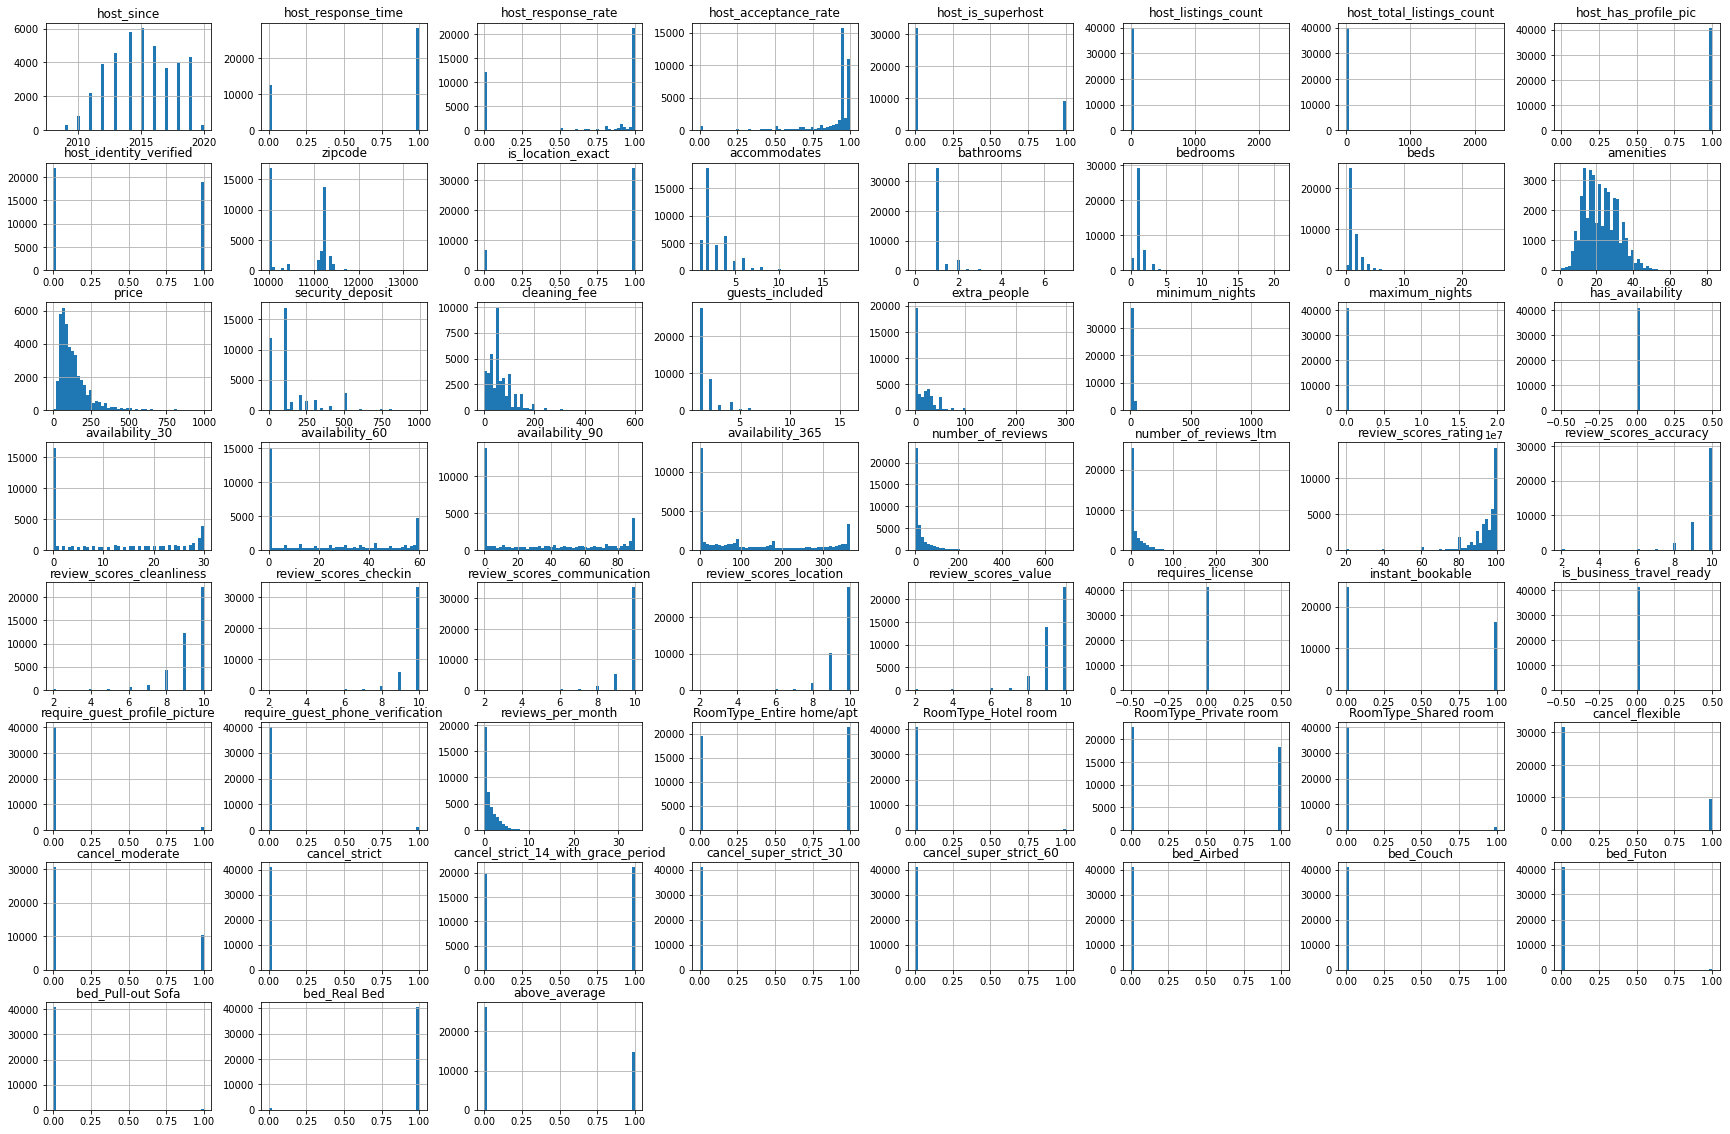

In [ ]:
#Display the histagram for the entire dataset after first step wrangling or encoding
airbnb_df.hist(bins=50, figsize=(30,20))
plt.show()

**Conclusion:** From visual insepction, our group noticed some interesting features:

1.   All Airbnbs provid "Real Bed" in their property
2.   None of the host holds license
3.   All hosts set up profile pictures
4.   Only approximately 1/4 of the hosts are "Super Host"
5.   None of the Airbnb is business ready in a city with heavy business travel need
6. No host has strict cancellation policy, the toughest policy is "cancel restricted within 14 days"



In [33]:
#list of meanglingless feature, same for the all the instance, based on visual inspection of the histogram
void_features = ['bed_Airbed', 'bed_Couch', 'bed_Futon','bed_Pull-out Sofa', 'bed_Real Bed','is_business_travel_ready','requires_license','has_availability','maximum_nights',
         'host_listings_count','host_has_profile_pic','host_total_listings_count','cancel_strict','cancel_super_strict_30','cancel_super_strict_60']

In [34]:
#drop the void features from the dataset
airbnb_cleaned = airbnb_df.drop(void_features, axis = 1)
airbnb_cleaned.shape

(40975, 44)

## **4. Word Cloud for Descriptive Features - EDA**

Writing effective description and the strategy to list amenities are critical and sometimes work as the decesive factors letting the user to make reseveration. Therefore, our group decide to perform NLP and create two word clouds for both the description and the amenities to find the most mentioned features and amenities host listed for their properities. NLTK has been used in this case.

In [ ]:
#nltk package import and installationm stopwords has been set to english
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
#download package use to identify nouns
nltk.download('averaged_perceptron_tagger')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
#drop missing value from the two need processing dataset
airbnb_description = airbnb_for_word['description'].dropna().tolist()
airbnb_amenities = airbnb_for_word['amenities'].dropna().tolist()

**Helper Method - Tokenize**

In [ ]:
# define the function for tokenized the content the function will capabe to distinguish all the nouns in the contents
def tokenized_content(content):
  from nltk.corpus import stopwords
  #stopwords setp to english
  stopwords = set(stopwords.words('english'))
  #identify nouns
  is_noun = lambda pos: pos[:2] == 'NN'
  tokens=nltk.word_tokenize(content)
  #set all contents to lower case
  tokens=[tokens.lower() for tokens in tokens if tokens.isalpha()]
  #tokenize contents to filtered out nouns and return filtered token in lower case
  noun_tokens = [tokens.lower() for (tokens,pos) in nltk.pos_tag(tokens) if is_noun(pos)]
  filtered_token = [i for i in noun_tokens if i not in stopwords]
  for i in range(len(filtered_token)):
    filtered_token[i] = filtered_token[i].lower()
  return filtered_token

In [ ]:
# tokenize the description list
temp_description = list(map(tokenized_content,airbnb_description))
description_tokens = []
for i in temp_description:
  for j in i:
    description_tokens.append(j)
# tokenize the amenities list
temp_amenities = list(map(tokenized_content,airbnb_amenities))
amenities_tokens = []
for i in temp_amenities:
  for j in i:
    amenities_tokens.append(j)

In [ ]:
#identify the most common 30 nouns mentioned in the description and amenities
description_most_common = Counter(description_tokens).most_common(30)
amenities_most_common = Counter(amenities_tokens).most_common(30)

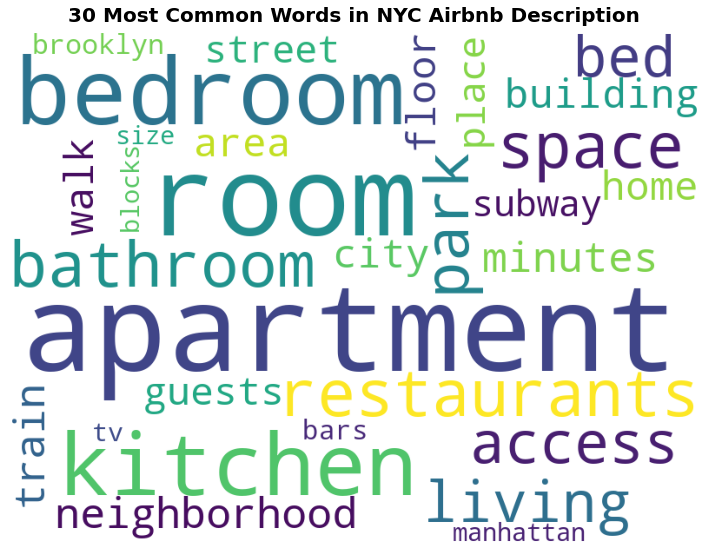

In [ ]:
#create the world cloud for 30 most common words mentioned in description
fig, ax = plt.subplots(figsize=(10,10))
description_wc = WordCloud(background_color="white",width=800, height=600).generate_from_frequencies(dict(description_most_common))
plt.imshow(description_wc)
plt.tight_layout(pad=0)
plt.title("30 Most Common Words in NYC Airbnb Description", weight = 'bold', fontdict={'fontsize': 20})
plt.axis('off')
plt.show()

**Interesting Finding**:

1.   Most hosts mentioned apartment, inferring the property type of most Airbnbs in NYC.

2.   Kitchen and Bathroom are the most mentioned layouts, inferring as the key selling points for Airbnbs in NYC.

3.   Manhattan and Brooklyen are the most mentioned districts, inferring either where most the Airbnbs located or the most popular destination in NYC.

4. Subway is the most mentioned transportation methods, inferring that distance to subway station are a key selling point for Airbnbs in NYC.

5.  Park, Resturnat, and Bar are most mentioned places, inferring that these are places that Airbnb guests visited or care the most when searching for Airbnbs in NYC.



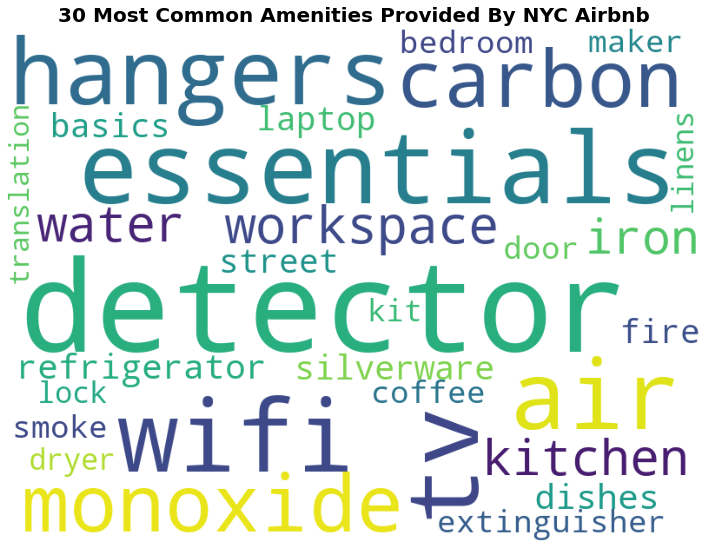

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
amenities_wc = WordCloud(background_color="white",width=800, height=600).generate_from_frequencies(dict(amenities_most_common))
plt.imshow(amenities_wc)
plt.tight_layout(pad=0)
plt.title("30 Most Common Amenities Provided By NYC Airbnb", weight = 'bold', fontdict={'fontsize': 20})
plt.axis('off')
plt.show()

**Interesting Finding**:


1.   Detecor is the most mentioned amenity, inferring that Airbnb mandate the host to list safety equipments installed, e.g. Fire/Smoke Detector, Monoxide Detector, Fire Extinguisher, etc.

2.   Essentials Amenities such as WIFI, TV, Water, Coffee Maker, Hangers, are mentioned the most, maching amenities available in hotel.

3. Workspace is also mentioned frequently to demonstrate the potential for business travel, but none of the Airbnbs in the Dataset is Business Ready.

4. Kitchen Equipment is also mentioned frequently, inferring that kitchen equipment is an important selling point.



##**5. Visualization - EDA**

Visualization is an important asepct for Exploratory Data Analysis and give us more in-depth understanding about the dataset we are working on. In this section, our group performs the following visaulization:



1.   Geographic Mapping Based on Zip Code
2.   Pairwise Visualization






### 5.1 Geographic Mapping
The data for mapping the zipcode to the actual New York City map is from the GitHub repository: https://github.com/nychealth/coronavirus-data.git

#### Airbnb Count Map

In [ ]:
#install geopandas as the package for geographic mapping
!pip install geopandas

In [ ]:
#package and geo data important
import geopandas as gpd
gdf_co = gpd.read_file('MODZCTA_2010.shp')
gdf_co.head()

In [ ]:
#group by zipcode determine number of Airbnbs in each location based on zip code
airbnb_count = airbnb_cleaned.groupby('zipcode').count()
airbnb_count = airbnb_count.reset_index()
airbnb_count = airbnb_count[['zipcode', 'host_since']]
airbnb_count.columns = ['zipcode', 'count']
airbnb_count.head()

,zipcode,count
0,10001,497
1,10002,1084
2,10003,822
3,10004,56
4,10005,283


In [ ]:
# convert modzcta to int to enable join
gdf_co = gdf_co.astype({'MODZCTA':'int64'})


# merge datasets on modzcta
df_merge_zcta= gdf_co.merge(airbnb_count, right_on = 'zipcode', left_on = 'MODZCTA')

# preview merged dataset
df_merge_zcta.head()

,MODZCTA,label,geometry,zipcode,count
0,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10001,497
1,10002,10002,"POLYGON ((985342.000 197658.000, 985336.000 19...",10002,1084
2,10003,10003,"POLYGON ((987412.000 202684.000, 987400.000 20...",10003,822
3,10004,10004,"MULTIPOLYGON (((982030.000 197212.000, 981958....",10004,56
4,10005,10005,"POLYGON ((982126.000 195468.000, 982080.000 19...",10005,283


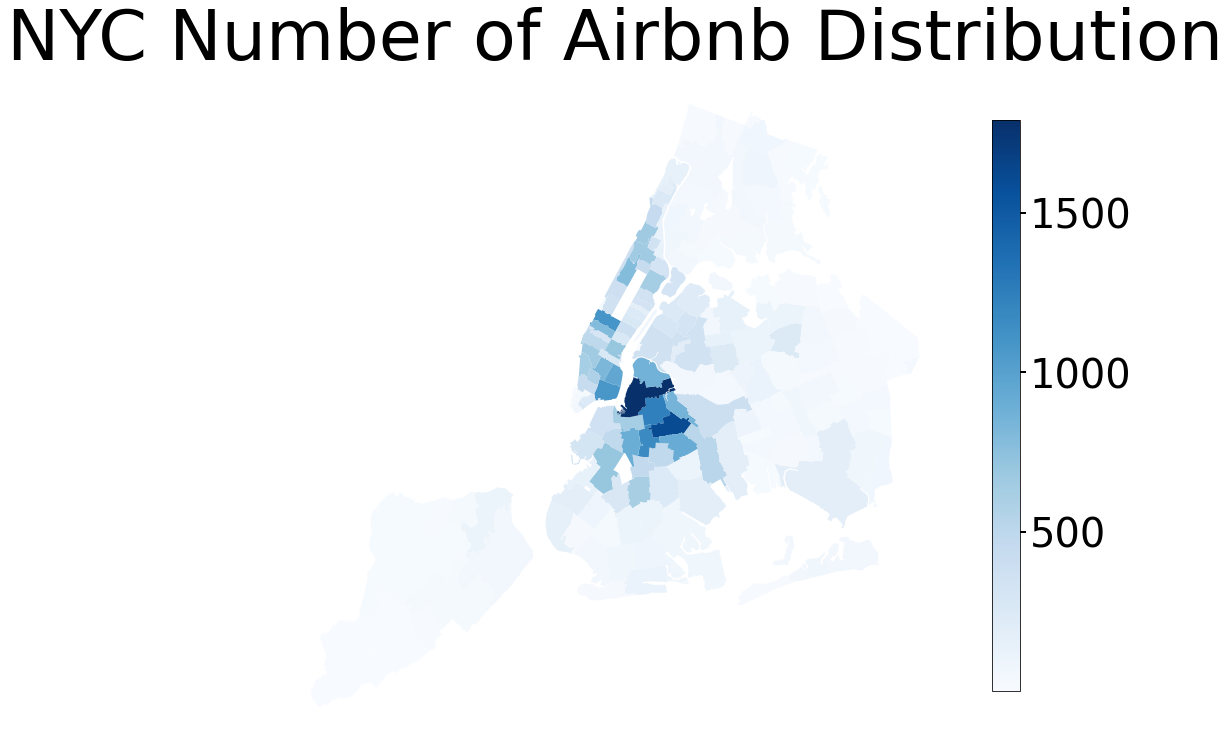

In [ ]:
# create map figure and axes
fig, ax = plt.subplots(figsize=(15,15))

# call .plot() method on df
ax = df_merge_zcta.plot(column = 'count', 
                        cmap='Blues', ax=ax,
                        legend=True,
                        legend_kwds={'shrink': 0.7})

# figure has two axes, cb is 2nd
cb_ax = fig.axes[1]

# set params for cb
cb_ax.tick_params(labelsize=40,
                  direction='out', 
                  length=6, 
                  width=2,
                  grid_alpha=1)

# set map title
ax.set_title("NYC Number of Airbnb Distribution", fontdict={'fontsize': 70}, loc='center')

# remove axis surrounding map
ax.set_axis_off()

**Interesting Finding**: 

The location with most of the Airbnbs are not in Manhattan.Instead, most of them are in Queens and Long Island City. Most of the Airbnbs in Manhattan are located in the East Village, Midtown close to the Central Park and Columbus Circle, and close to the Columbia University.



#### Pricing Map

In [ ]:
#group by zipcode determine the average price of Airbnbs in each location based on zip code
airbnb_price = airbnb_cleaned.groupby('zipcode').mean()
airbnb_price = airbnb_price.reset_index()
airbnb_price = airbnb_price[['zipcode', 'price']]
airbnb_price.head()

,zipcode,price
0,10001,200.752515
1,10002,162.896679
2,10003,192.922141
3,10004,212.267857
4,10005,231.159011


In [ ]:
# convert modzcta to int to enable join
gdf_co = gdf_co.astype({'MODZCTA':'int64'})


# merge datasets on modzcta
df_merge_zcta= gdf_co.merge(airbnb_price, right_on = 'zipcode', left_on = 'MODZCTA')

# preview merged dataset
df_merge_zcta.head()

,MODZCTA,label,geometry,zipcode,price
0,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10001,200.752515
1,10002,10002,"POLYGON ((985342.000 197658.000, 985336.000 19...",10002,162.896679
2,10003,10003,"POLYGON ((987412.000 202684.000, 987400.000 20...",10003,192.922141
3,10004,10004,"MULTIPOLYGON (((982030.000 197212.000, 981958....",10004,212.267857
4,10005,10005,"POLYGON ((982126.000 195468.000, 982080.000 19...",10005,231.159011


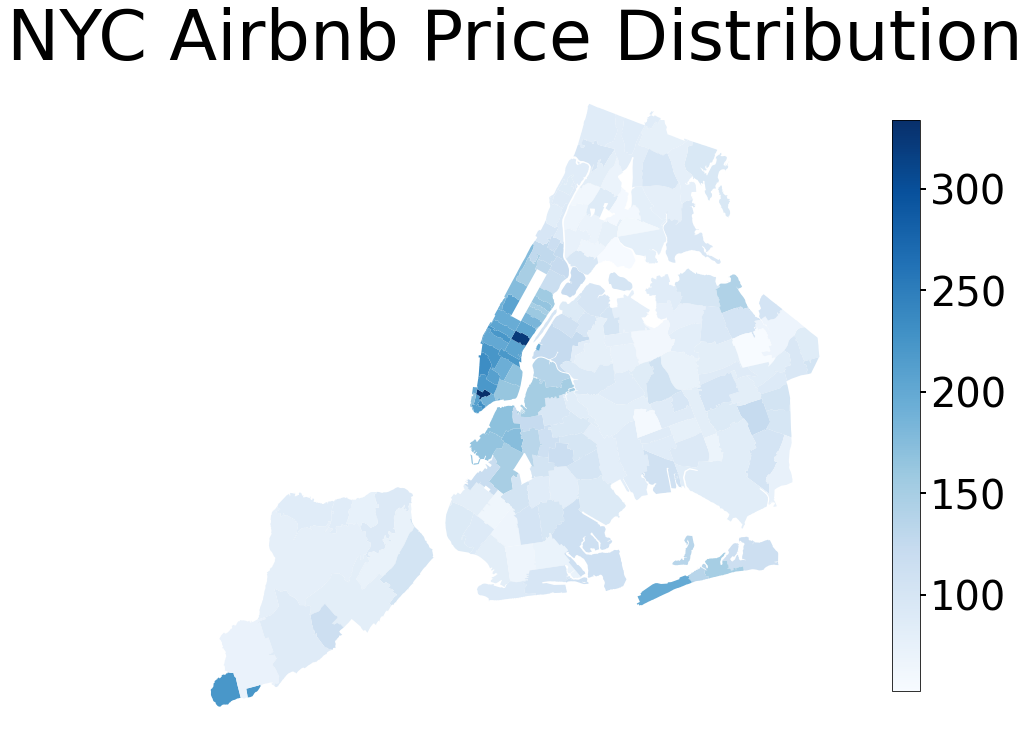

In [ ]:
# create map figure and axes
fig, ax = plt.subplots(figsize=(15,15))

# call .plot() method on df
ax = df_merge_zcta.plot(column = 'price', 
                        cmap='Blues', ax=ax,
                        legend=True,
                        legend_kwds={'shrink': 0.7})

# figure has two axes, cb is 2nd
cb_ax = fig.axes[1]

# set params for cb
cb_ax.tick_params(labelsize=40,
                  direction='out', 
                  length=6, 
                  width=2,
                  grid_alpha=1)

# set map title
ax.set_title("NYC Airbnb Price Distribution", fontdict={'fontsize': 70}, loc='center')

# remove axis surrounding map
ax.set_axis_off()

**Interesting Finding:**

It is not suprised that the average price of Airbnbs in Manhattan are the highest in NYC, ranging from \$200 - $300. Brooklyn has the second highest average price for regions close to Manhattan. It is also interesting to see that Tottenville in Staten Island and the Rockway Beach region also has higher average compared to its counterparts nearby and our group infers that this is due to the fact that most of the Airbnb in these two regions have the property type of house and mainly preferred by user for holiday and weekend getaways.

#### Host Since Map

In [ ]:
#group by zipcode determine the start time for hosts on Airbnbs in each location based on zip code
airbnb_host = airbnb_cleaned.groupby('zipcode').min()
airbnb_host = airbnb_host.reset_index()
airbnb_host = airbnb_host[['zipcode', 'host_since']]
# airbnb_host['host_since'] = [int(x) for x in airbnb_host['host_since']]
airbnb_host.head()

,zipcode,host_since
0,10001,2008
1,10002,2009
2,10003,2009
3,10004,2011
4,10005,2011


In [ ]:
# convert modzcta to int to enable join
gdf_co = gdf_co.astype({'MODZCTA':'int64'})


# merge datasets on modzcta
df_merge_zcta= gdf_co.merge(airbnb_host, right_on = 'zipcode', left_on = 'MODZCTA')

# preview merged dataset
df_merge_zcta.head()

,MODZCTA,label,geometry,zipcode,host_since
0,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",10001,2008
1,10002,10002,"POLYGON ((985342.000 197658.000, 985336.000 19...",10002,2009
2,10003,10003,"POLYGON ((987412.000 202684.000, 987400.000 20...",10003,2009
3,10004,10004,"MULTIPOLYGON (((982030.000 197212.000, 981958....",10004,2011
4,10005,10005,"POLYGON ((982126.000 195468.000, 982080.000 19...",10005,2011


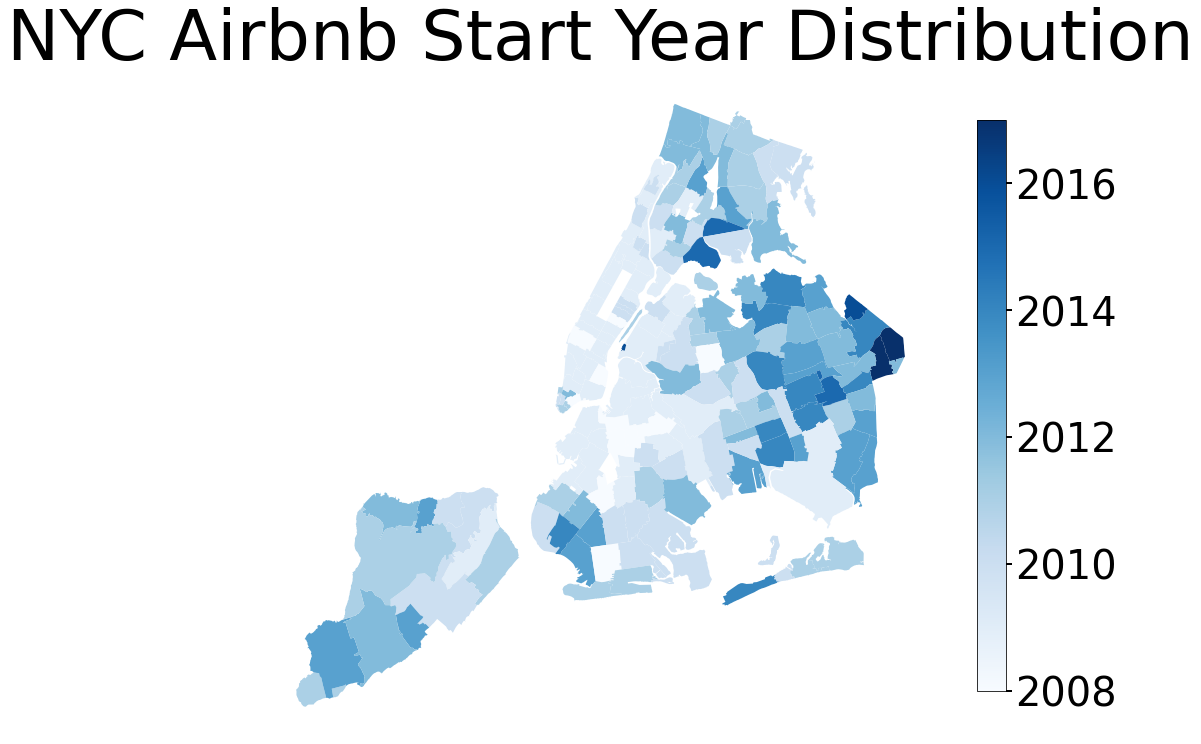

In [ ]:
# create map figure and axes
fig, ax = plt.subplots(figsize=(15,15))

# call .plot() method on df
ax = df_merge_zcta.plot(column = 'host_since', 
                        cmap='Blues', ax=ax,
                        legend=True,
                        legend_kwds={'shrink': 0.7})

# figure has two axes, cb is 2nd
cb_ax = fig.axes[1]

# set params for cb
cb_ax.tick_params(labelsize=40,
                  direction='out', 
                  length=6, 
                  width=2,
                  grid_alpha=1)

# set map title
ax.set_title("NYC Airbnb Start Year Distribution", fontdict={'fontsize': 70}, loc='center')

# remove axis surrounding map
ax.set_axis_off()

**Interesting Finding:**

Hosts in Manhattan and Brooklyn are the earlist to start their Airbnb business before 2010, corresponding to the demand and popularity in NYC. Manhattan and Brooklyn are the startig point for the Airbnb business in NYC and more hosts in other distrction, Queens, Long Island City, Bronx, and Staten Island, gradually join the business in later years.

### 5.2 Pairwise Visualization
The pairwise comparison used the FacetGrid and PairPlot to visualize the related correlation among selected features. The FacetGrid shows the relationship between the regional zipcode and the review score rating, divided by whether the price of the Airbnb is above average. As for the PairPlot figure, we selected ten features including ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'zipcode', 'price',
       'security_deposit', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_value'] with 'above_average' as the category for the legend. 

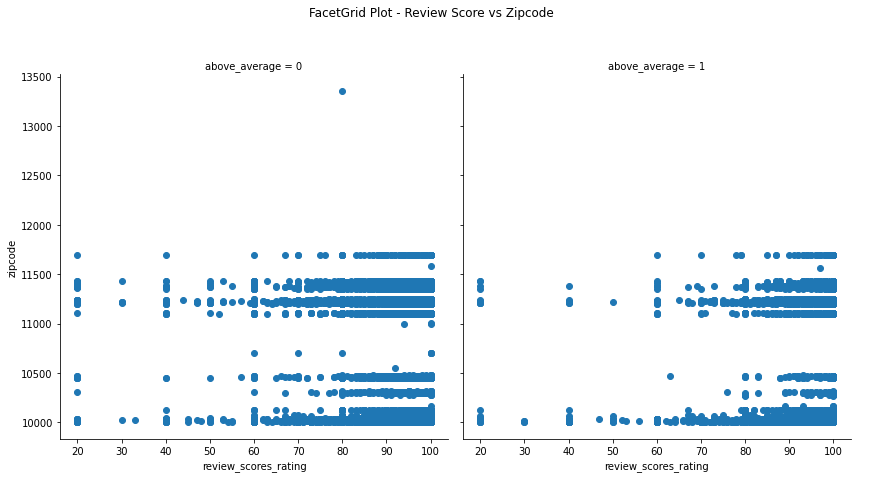

In [ ]:
# create FacetGrid plot visualizing the relationship between regional zipcode and review score rating
facet = sns.FacetGrid(airbnb_cleaned, col = 'above_average', height = 6)
facet.map(plt.scatter, "review_scores_rating", "zipcode")
facet.add_legend()
facet.fig.suptitle('FacetGrid Plot - Review Score vs Zipcode', y = 1.1)
plt.show()

In the FacetGrid plot, we can see that for both price above and below average, most of the rating are centered toward higher socre. However, it is not supprise that the above average group would have a more dense cluster in the higher score region and the below average group's cluster is somewhat more expend towards 50 score. 

In [ ]:
# select appropriate feature for pairwise visualization 
airbnb_pair = airbnb_cleaned[['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'zipcode', 'price',
       'security_deposit', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_value', 'above_average']]
g = sns.pairplot(airbnb_pair, hue ='above_average')
g.fig.suptitle("PairPlot Visualization on the Selected Features Based on above_average Label", y = 1.05)
# to show
plt.show()

Output hidden; open in https://colab.research.google.com to view.

From the pairwise visualization of the selected features, we can essentially obtain a lot information regarding the distribution as well as their in-between relationships. For example, we can get a clear intuition about how we set up the label for above_average looking at the price plot. In addition, in a lot of plots we can see mixed cluster for blue and orange legends corresponding to the below and above avearge label, but we can still see that many features would be slightly correlated to the label such as that the higher price Airbnb would have better review and more security deposite. 

# **PART II Regression Analysis on Airbnb Price**
Up until now we have finished our data processing and visualization part. Based on manual checking and visualization, we have selected a decent amount of features that are appropriate for machine learning analysis. In this part, we accomplished regression analysis using the Airbnb price as label, and tried multiple machine learning models with and without the principal component analysis. The evaluation metrics we used for this part is the RMSE (root mean squared error). Our baseline model is a simple linear regresion model, and we also tried the PCA, elasticnet and xgboost with different hyperparameters as well as the deep learnining neural network structure

##**6. Feature & Label Set-Up**
In order to get separate dataframe for analysis, we separated the airbnb data into two dataframes containing the feature and label. 

In [35]:
# create feature dataframe for both regression and classification
airbnb_class_df = airbnb_cleaned.drop(columns='price')
class_columns = airbnb_class_df.columns
airbnb_reg_df = airbnb_cleaned.drop(columns='above_average')
reg_columns = airbnb_reg_df.columns

In [36]:
# create label dataframe for regression and classification
class_label = ["above_average"]
class_feature = list(set(class_columns) - set(class_label))
reg_label = ['price']
reg_feature = list(set(reg_columns) - set(reg_label))

In [37]:
airbnb_class_label = airbnb_class_df[class_label]
airbnb_class_label

,above_average
0,1
1,1
2,1
3,0
4,0
...,...
41325,0
41326,1
41327,0
41328,0


In [38]:
airbnb_class_feature = airbnb_class_df[reg_feature]
airbnb_class_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40975 entries, 0 to 41329
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   host_acceptance_rate                40975 non-null  float64
 1   extra_people                        40975 non-null  int64  
 2   availability_30                     40975 non-null  int64  
 3   RoomType_Shared room                40975 non-null  uint8  
 4   beds                                40975 non-null  float64
 5   review_scores_accuracy              40975 non-null  int64  
 6   bedrooms                            40975 non-null  int64  
 7   RoomType_Hotel room                 40975 non-null  uint8  
 8   accommodates                        40975 non-null  int64  
 9   is_location_exact                   40975 non-null  int64  
 10  review_scores_location              40975 non-null  int64  
 11  reviews_per_month                   40975

In [39]:
airbnb_reg_label = airbnb_reg_df[reg_label]
airbnb_reg_label

,price
0,145
1,199
2,165
3,59
4,48
...,...
41325,130
41326,600
41327,60
41328,95


In [40]:
airbnb_reg_feature = airbnb_reg_df[reg_feature]
airbnb_reg_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40975 entries, 0 to 41329
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   host_acceptance_rate                40975 non-null  float64
 1   extra_people                        40975 non-null  int64  
 2   availability_30                     40975 non-null  int64  
 3   RoomType_Shared room                40975 non-null  uint8  
 4   beds                                40975 non-null  float64
 5   review_scores_accuracy              40975 non-null  int64  
 6   bedrooms                            40975 non-null  int64  
 7   RoomType_Hotel room                 40975 non-null  uint8  
 8   accommodates                        40975 non-null  int64  
 9   is_location_exact                   40975 non-null  int64  
 10  review_scores_location              40975 non-null  int64  
 11  reviews_per_month                   40975

## **7. Visualization for Regression Analysis**
Before we do actual analysis on the airbnb data, we would also want to do some visualization related to the natural clustering and correlation among the selected features for regression analysis. We believe that this will help us further understand how the data would contribute to the results we get and hopefully further improve the performance of our model analysis.

### 7.1 Standardization on Training and Testing Data
Since we know that the principal component analysis is not scale invariant, we would like to fisrt standardize the data before applying the PCA algorithm. 

In [ ]:
# Do standardization for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(airbnb_reg_feature)
x_train_sc = scaler.transform(airbnb_reg_feature)

### 7.2 PCA 2 Component
First we visualized the first two component from the principal component analysis and we can see from the plot that the overall trend of the fisrt two principal component are mostly linear but still a lot of noisy points still exists orthogonal to the major cluster. However, unfortunately we did not observe any clear clustering of the data from the principal component analysis

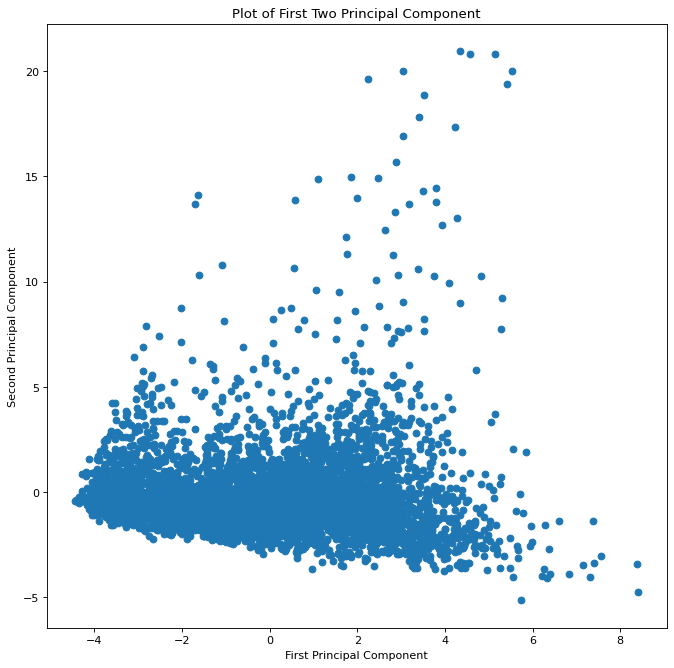

In [ ]:
# Principal Component Analysis using first two component for visualizaiton
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(x_train_sc)
x_train_pca = pca.transform(x_train_sc)[:5000]
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(x_train_pca[:,0], x_train_pca[:,1])
plt.title("Plot of First Two Principal Component")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

### 7.3 t-SNE
Since the principal component analysis only disclosed a large cluster but cannot clearly see if we can cluster those data, we further performed the t-SNE analysis to check for a clearer natural clustering. As we can see from the plot, there are clear boundaries between each of the cluster in the t-SNE plot. We currently may not be able to identify the exact label for those clsutering, we believe that will definitely be associate with some of the features including the fees, reviews, and zipcode. 

In [ ]:
# t-SNE analysi for clearer clustering 
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(x_train_sc)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


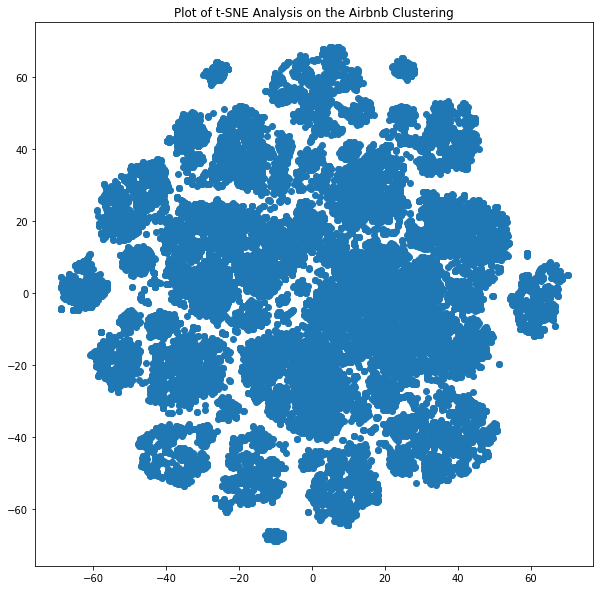

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(X_embedded[:,0],X_embedded[:,1])
plt.title("Plot of t-SNE Analysis on the Airbnb Clustering")
plt.show()

### 7.4 Correlation Matrix
The correlation matrix is the final step we would like to go through before actually perform the machine learning model. In this figure, we used the heatmap to visualize the correlation matrix between each of the features in our airbnb data. In this case, most of the features are not highly correlated with each other which would be ideal for applyting those features into the machine learning model. In addition, we would also expect further adjustment of the features by applying regularization terms to the model latter. 

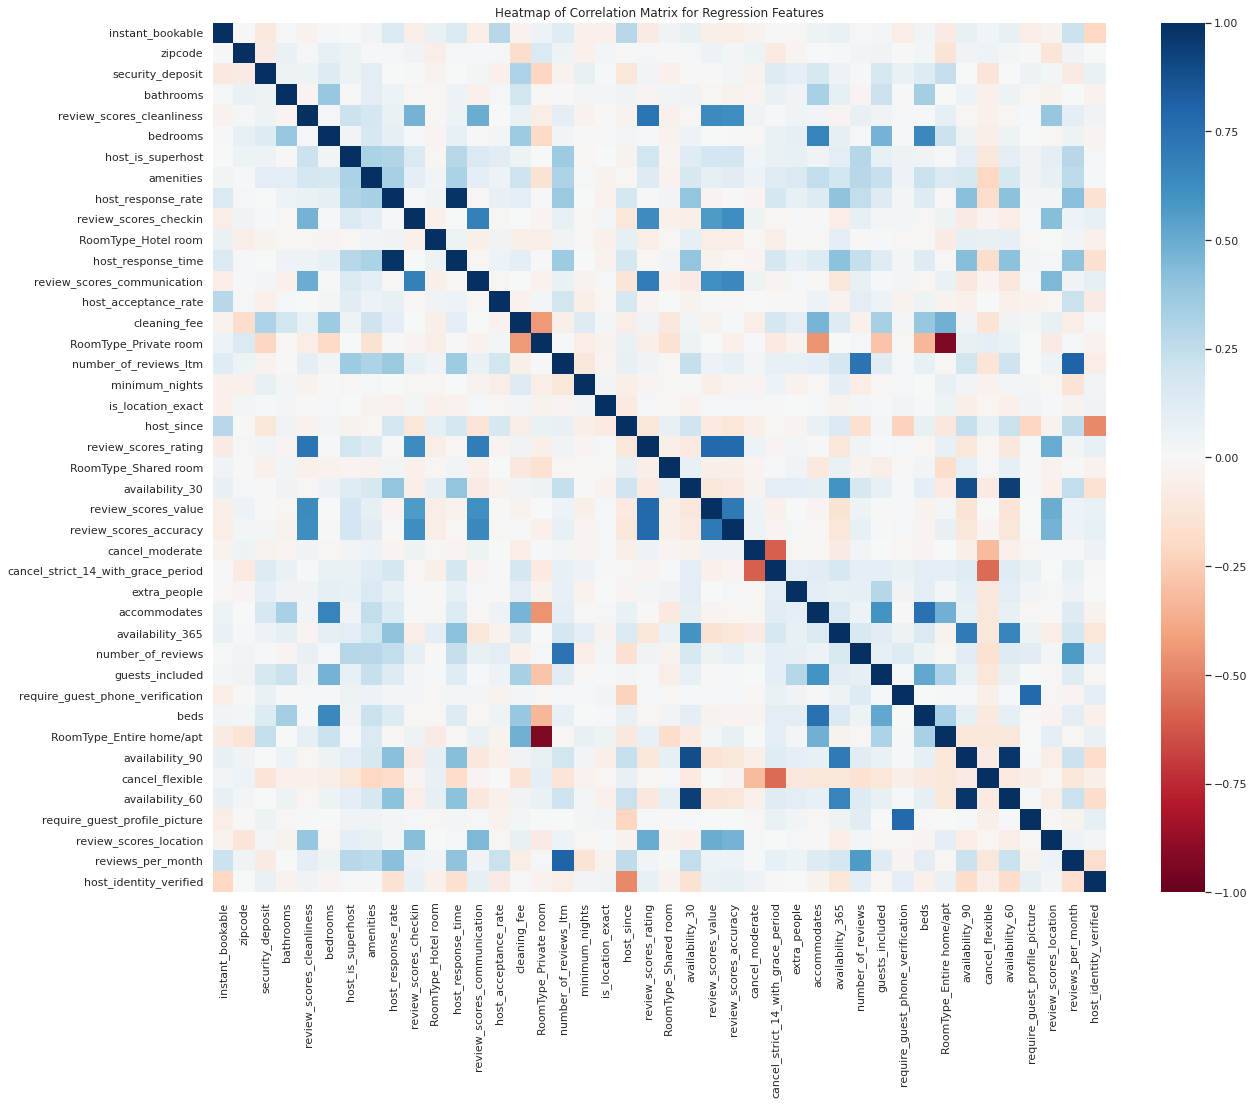

In [ ]:
# Get the correlation matrix
feature_corr = airbnb_reg_feature.corr()

# Plot correlation heatmap
# change figure size
sns.set(rc = {'figure.figsize':(20,16)})
ax = sns.heatmap(feature_corr, cmap = 'RdBu', vmin = -1, vmax = 1)
ax.set_title('Heatmap of Correlation Matrix for Regression Features')
plt.show()

## **8. Data Split for Regression Analysis**
In this part, we essentially are splitting the data into training and testing df for training the machine learning models and evaluate their performance. 

In [ ]:
# check the data type in eacn feature
airbnb_reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40975 entries, 0 to 41329
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   host_since                          40975 non-null  int64  
 1   host_response_time                  40975 non-null  int64  
 2   host_response_rate                  40975 non-null  float64
 3   host_acceptance_rate                40975 non-null  float64
 4   host_is_superhost                   40975 non-null  int64  
 5   host_has_profile_pic                40975 non-null  int64  
 6   host_identity_verified              40975 non-null  int64  
 7   zipcode                             40975 non-null  int64  
 8   is_location_exact                   40975 non-null  int64  
 9   accommodates                        40975 non-null  int64  
 10  bathrooms                           40975 non-null  float64
 11  bedrooms                            40975

In [ ]:
from sklearn.model_selection import train_test_split

train_size = 0.8
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(airbnb_reg_feature, airbnb_reg_label, test_size=test_size, random_state=42)

## **9. Baseline Linear Regression on Airbnb Price**
The baseline model for the regression analysis is simply a linear regression model from sklearn. We did not apply any hyperparameter to the classifier setup and the rmse for the baseline model we got is 75.699

In [ ]:
# set up the linear regression classfier and train using the data
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [ ]:
# evaluate baseline performance using RMSE
from sklearn.metrics import mean_squared_error
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_linear

75.69865940472556

## **10. Principal Component Analysis and Regression**
By applying PCA to the data, we visualized and choosed the first 38 principal component for the regression and that would explain more than 95% of the varinace. In this case, the PCA did not provided a better performance for the linear regression model. Instead, the RMSE is 75.702 which increased a little bit

In [ ]:
# standardization for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

In [ ]:
# set up PCA with full number of component
pca = PCA()
pca_fit = pca.fit(x_train_sc)

In [ ]:
# calculate the cumulative explained varinace ratios
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = []
update = 0
for i in explained_variance_ratios:
  update = update + i
  cum_evr.append(update)

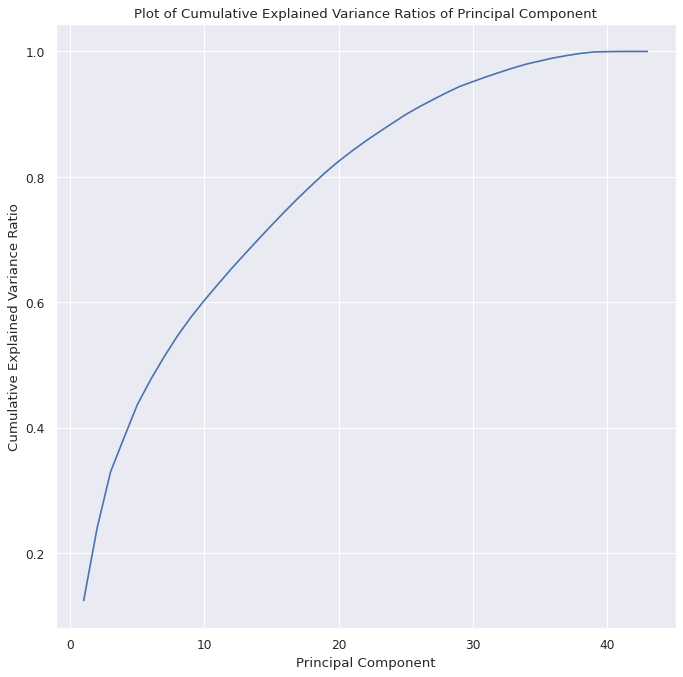

In [ ]:
# visualization for the expalined variance ratio
x = len(explained_variance_ratios)
x_axis = [*range(x)]
x_axis = [x+1 for x in x_axis]

plt.figure(figsize=(10, 10), dpi=80)
plt.plot(x_axis, cum_evr)
plt.title("Plot of Cumulative Explained Variance Ratios of Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.show()

In [ ]:
# choose the optimal number of component
optimal_component_num = 38

In [ ]:
# Instantiate, fit, predict, and score linear regression
pca = PCA(n_components = optimal_component_num)
x_train_pca = pca.fit_transform(x_train_sc)

In [ ]:
# setup new linear regression classifier and train using PCA component
clf = LinearRegression()
clf.fit(x_train_pca, y_train)
x_test_pca = pca.transform(x_test_sc)
y_pred = clf.predict(x_test_pca)

In [ ]:
# Evaluate using RMSE
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred))

75.70174318738947

## **11. Elastic Net (Without PCA)**
The elastic net is a fancier version of linear regression. Essentially by adding both the L1 and L2 norm for the regularizaiton, we can have both benefits of ridge and lasso regression. We have setup the hyperparameter for different alpha values for penalty and l1_ratio for different ratio of L1 and L2 penalty for the model. After those models are executed, we ranked their RMSE in ascending order and will pick the smallest RMSE for the results. It is acually a surprise that the best model from the elastic net is our baseline linear regression model with alpha and l1_ratio equal to 0. In this case, the best RMSE for the elasticnet is still 75.699

In [ ]:
# set up hyperparameters for alpha and l1_ratio
from sklearn.linear_model import ElasticNet
alpha = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
l1_ratio = np.arange(0, 1, 0.1)
# create dataframe for stroing the results
results = pd.DataFrame(columns = ['Alpha', 'Ratio', 'RMSE'])

In [ ]:
# train classifier based on each pair of hyperparameters
for a in alpha:
  for r in l1_ratio:
    print(a, r)
    clf = ElasticNet(alpha=a, l1_ratio=r)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    # calculate rmse
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # store the results
    temp = [a, r, rmse]
    results.loc[len(results)] = temp

In [ ]:
# sort results based on RMSE
results = results.sort_values(by=['RMSE'], ascending=True)
results.head()

,Alpha,Ratio,RMSE
0,0.0,0.0,75.698939
1,0.0,0.1,75.698939
2,0.0,0.2,75.698939
3,0.0,0.3,75.698939
4,0.0,0.4,75.698939


## **12. Elastic Net (With PCA)**
In this section, we still applied the elasticnet model but the data we are using is changed to the principal component from previous analysis. In this case, the best pair is using alpha value equal to 0.01 and L1_ratio equal to 0.9. However, the results is still not get better with a RMSE value of 75.701. 

In [ ]:
# set up hyperparameteres for training
from sklearn.linear_model import ElasticNet
alpha = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
l1_ratio = np.arange(0, 1, 0.1)
# create dataframe for storing results
results = pd.DataFrame(columns = ['Alpha', 'Ratio', 'RMSE'])

In [ ]:
# train the elasticnet based on hyperparameters and using the PCA data
for a in alpha:
  for r in l1_ratio:
    clf = ElasticNet(alpha=a, l1_ratio=r)
    clf.fit(x_train_pca, y_train)
    y_pred = clf.predict(x_test_pca)
    # calcualte rmse
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # store the rmse to results dataframe
    temp = [a, r, rmse]
    results.loc[len(results)] = temp

In [ ]:
results = results.sort_values(by=['RMSE'], ascending=True)
results.head()

,Alpha,Ratio,RMSE
49,0.01000,0.9,75.701496
39,0.00100,0.9,75.701703
29,0.00010,0.9,75.701739
19,0.00001,0.9,75.701743
9,0.00000,0.9,75.701743


XGBoost, which stands for Extreme Gradient Boosting, is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. At first, our group had tried to perform regression using Random Forest model to conduct regression on the price. However, the performance of the model is not ideal, and cannot converge using our current resources under reasonable time (under 5 hours). Our group also tried to solve the problem using GPU, PySpark, but we had encountered a problem that Spark did not support our label amount (more than 100) and there are few limited resources. 

After searching on Kaggle, Github, and GeekforGeeks , our group has identified XGBoost, which a popular model used for price prediction. It is capable to provide outstanding accuracy and performance compared to regular Random Forest. A simplified structure of the XGBoost has been shown below. Our group also perform tunning on the hyperparameter, maximum depth of the tree, under PCA and without PCA condition to identify the best model for predictions.

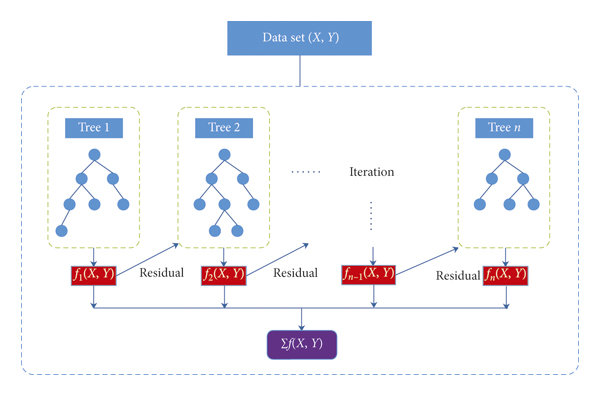

Source : Advances in Meteorology - Machine Learning



## **13. XGBoost (Without PCA)**

XGboost Without PCA has been conducted in this section. Overfitting can be seen from the model as the training accuracy is close to 1.00 while the testing accuracy still remains between 0.6 and 0.7. RMSE falls in the range between 60% - 70%.

In [ ]:
#Import XGBoost Package
import xgboost as xgb
#Helper Method for XGBoost Training
def xgb_train(x_train, x_test, y_train, y_test, depth_list, train_accuracy_list, test_accuracy_list, rmse_xgb_list):
  for depth in depth_list: 
    #hyperparameter: obejective as squarederror, tried linear and tree but the system decided squarederror is the best regressor for our case,
    #max_depth represent the maximum depth of tree
    xg = xgb.XGBRegressor(objective ='reg:squarederror',max_depth = depth)
    # train the xgboost model
    xg.fit(x_train,y_train.values.ravel())
    #prediction using the model
    y_pred = xg.predict(x_test)
    #calculate training accuracy
    train_acc = xg.score(x_train, y_train)
    train_accuracy_list.append(train_acc)
    #calculate prediction accuracy
    test_acc = xg.score(x_test, y_test)
    test_accuracy_list.append(test_acc)
    #calucalte RMSE
    xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_xgb_list.append(xgb_rmse)
    print("XGBoost Depth: %s, train_score: %s, test_score: %s, RMSE: %s" % (depth, train_acc, test_acc,xgb_rmse))

In [ ]:
# call the helper to train XGBoost without PCA
depth_list= range(2, 22, 2);
train_xgb_list = []
test_xgb_list = []
rmse_xgb_list = []
xgb_train(x_train,x_test,y_train, y_test, depth_list, train_xgb_list, test_xgb_list,rmse_xgb_list)

XGBoost Depth: 2, train_score: 0.603127032541681, test_score: 0.6061185043944781, RMSE: 69.48651822895366
XGBoost Depth: 4, train_score: 0.6966073376247354, test_score: 0.6603278717011452, RMSE: 64.52792769456433
XGBoost Depth: 6, train_score: 0.795009817075352, test_score: 0.6827085371900609, RMSE: 62.36586571723823
XGBoost Depth: 8, train_score: 0.8881339198112351, test_score: 0.6816386917980459, RMSE: 62.47092004931897
XGBoost Depth: 10, train_score: 0.9522274492146949, test_score: 0.6801041499907687, RMSE: 62.62129792850821
XGBoost Depth: 12, train_score: 0.9837446886315654, test_score: 0.6649066938752992, RMSE: 64.09152981926084
XGBoost Depth: 14, train_score: 0.9961612807814784, test_score: 0.6501666712151482, RMSE: 65.48598331112171
XGBoost Depth: 16, train_score: 0.999199914929034, test_score: 0.6441400664336794, RMSE: 66.04764066507657
XGBoost Depth: 18, train_score: 0.9998089742305207, test_score: 0.6413152582289272, RMSE: 66.30926484784494
XGBoost Depth: 20, train_score: 0.9

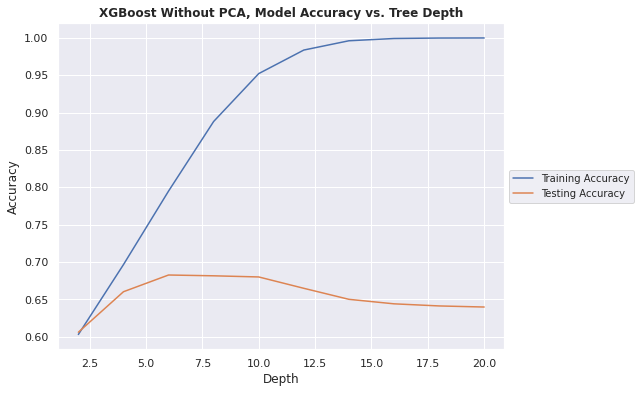

In [ ]:
#plot the training and testing accuracy to demonstrate the trend, overfitting start to show after depth > 10
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(depth_list,train_xgb_list,label='Training Accuracy')
plt.plot(depth_list,test_xgb_list,label='Testing Accuracy')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("XGBoost Without PCA, Model Accuracy vs. Tree Depth", weight = 'bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 10)
plt.show()

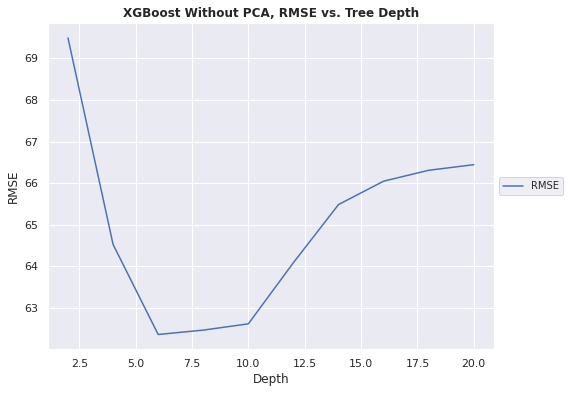

In [ ]:
#RMSE plot also demonstrate overfitting start to occur after depth > 10
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(depth_list,rmse_xgb_list,label='RMSE')
plt.xlabel("Depth")
plt.ylabel("RMSE")
plt.title("XGBoost Without PCA, RMSE vs. Tree Depth", weight = 'bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 10)
plt.show()

From the plot and the printed results, the best model is shown below:

1.   XGBoost Depth: 6
2.   Training Accuracy: 0.795009817075352
3.   Testing Accuracy: 0.6827085371900609
4.   RMSE: 62.36586571723823


## **14. XGBoost (With PCA)**

XGboost With PCA has been conducted in this section and shows slight worse performance compared to the model without PCA. Overfitting can be seen from the model as the training accuracy is close to 1.00 while the testing accuracy still remains between 0.5 and 0.6. RMSE falls in the range between 70% - 80%.

In [ ]:
# call the helper to train XGBoost with PCA
depth_list= range(2, 22, 2);
train_xgb_list = []
test_xgb_list = []
rmse_xgb_list = []
xgb_train(x_train_pca,x_test_pca,y_train, y_test, depth_list, train_xgb_list, test_xgb_list,rmse_xgb_list)

XGBoost Depth: 2, train_score: 0.5291064777647829, test_score: 0.5218634381953651, RMSE: 76.55855697023067
XGBoost Depth: 4, train_score: 0.6467651426070672, test_score: 0.5728116190044799, RMSE: 72.36481859723258
XGBoost Depth: 6, train_score: 0.7694655367642071, test_score: 0.5872802064896205, RMSE: 71.12878832935095
XGBoost Depth: 8, train_score: 0.8775646490083256, test_score: 0.5922000916444019, RMSE: 70.70356686953664
XGBoost Depth: 10, train_score: 0.95398335571275, test_score: 0.5884857292829284, RMSE: 71.0248314996464
XGBoost Depth: 12, train_score: 0.9864197315619023, test_score: 0.5892781341017406, RMSE: 70.95641645062977
XGBoost Depth: 14, train_score: 0.9966330962106508, test_score: 0.5788010030008508, RMSE: 71.85573333079762
XGBoost Depth: 16, train_score: 0.9992744120716072, test_score: 0.5695918879429238, RMSE: 72.63701452797773
XGBoost Depth: 18, train_score: 0.9998340479573065, test_score: 0.554715323268463, RMSE: 73.8816586745597
XGBoost Depth: 20, train_score: 0.999

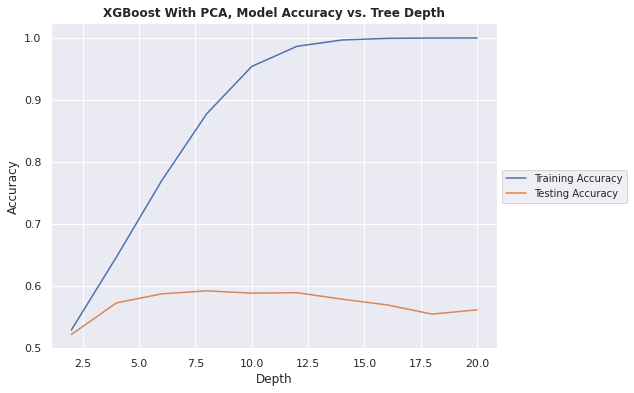

In [ ]:
#plot the training and testing accuracy to demonstrate the trend, overfitting start to show after depth > 10
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(depth_list,train_xgb_list,label='Training Accuracy')
plt.plot(depth_list,test_xgb_list,label='Testing Accuracy')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("XGBoost With PCA, Model Accuracy vs. Tree Depth", weight = 'bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 10)
plt.show()

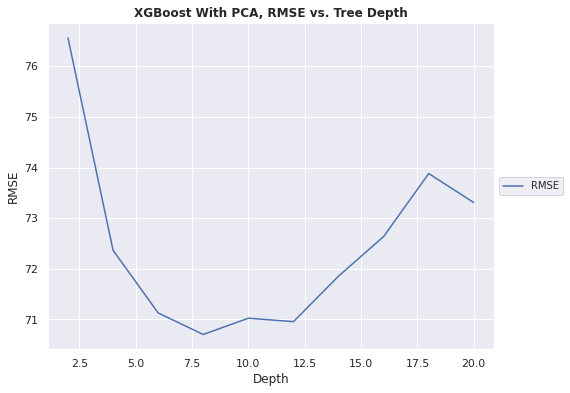

In [ ]:
#RMSE plot also demonstrate overfitting start to occur after depth > 10
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(depth_list,rmse_xgb_list,label='RMSE')
plt.xlabel("Depth")
plt.ylabel("RMSE")
plt.title("XGBoost With PCA, RMSE vs. Tree Depth", weight = 'bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 10)
plt.show()

From the plot and the printed results, the best model is shown below:

1.   XGBoost Depth: 8
2.   Training Accuracy: 0.8775646490083256
3.   Testing Accuracy: 0.5922000916444019
4.   RMSE: 70.70356686953664

## **15. Deep Learning**

We also performed regression using deep learning models. We found that the same features used to perform PCA and linear regression did not have good performance when used with a deep learning model but we did find that using different batch sizes and model structures had signifianct impacts on the Mean Squared Loss on testing and training data sets. A traditional 80/20 split was used on the available data with the model being training on 80% of the data and tested on the remaining 20%.  

Some of our observations in deep learning experiments were (The models were all trained for 500 epochs, to allow us to perform different time frame) :


*   While in traditional image based tasks, deep networks have been shown to exhibit much better performance, we have found, due to the nature of the features used, wider networks have has better results on the whole. 
*   Batch Size was shown to have a significant impact on the performance of our models, we belive that this is due to the fact that larger batch sizes have a tendency to smooth out outliers in the training data.
*   We also found that after a certain point, our models begin to heavily overfit the training data with test results being incongruent to model training performance. 



###utilities

Several Utility functions and classes were defined to aid in the training and testing of our network

In [ ]:
#Package import
import torch
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import requests
import io
from urllib.request import urlopen
import pandas as pd
import sklearn.model_selection as sk

In [ ]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

#normalizing elements    
def normalize(x):
    x_normed = x / x.max(0)[0]
    return x_normed

class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y


    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

###Deep Learning Regression Model

The deep learning model used for regression consisted of 4 linear layers. In testing different network depths were tested and four was found to the point of diminising returns in adding layers. We also found that adding parameters past point, slowed doing training to a large extent without significantly improving model results. A dropout layer was added to reduce overfitting on the training data. Between each activation layer, a Linear Rectified Unit activation function was used. 

In [ ]:
class RegNet(nn.Module):
    def __init__(self):
        super(RegNet, self).__init__()
        self.fc = nn.Sequential(nn.Linear(43,256),
                                nn.ReLU(),
                                nn.Linear(256, 512),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(512,512),
                                nn.ReLU(),
                                nn.Linear(512, 1),
                                )
        

    def forward(self, x):
        output = self.fc(x)
        return output

The training loss for each epoch was stored for plotting

In [ ]:
def train(model, device, train_loader, optimizer, epochs=100,batch_size=50):
  training_losses = []
  train_loader.to(device)
  for epoch in range(epochs):
      epoch_loss = 0
      for i in range(int(train_loader.shape[0]/batch_size)-1):
          model.train()
          optimizer.zero_grad()
          data = train_loader[i*50:(i+1)*50,:-1]
          target = train_loader[i*50:(i+1)*50,-1]
          output = model(data)
          output = torch.squeeze(output)
          loss = F.mse_loss(output, target,reduction='mean')
          loss.backward()
          optimizer.step()
          epoch_loss+=float(loss.data)    
      epoch_loss=(epoch_loss/((train_loader.shape[0]/batch_size)-1))    
      training_losses.append(epoch_loss)   
      if(epoch%1==0):   
          print("epoch:",epoch," average training loss:",epoch_loss) 

  return epoch_loss,np.array(training_losses)      

def test(model, device, test_loader):
    #sets model in eval mode
    model.eval()
    test_loss = 0
    data = test_loader[:,:-1].to(device)
    target = test_loader[:,-1].to(device)
    with torch.no_grad():
      output = model(data)
      output = torch.squeeze(output)
      test_loss =  F.mse_loss(output, target,reduction='mean')   
    # print("Test loss:",test_loss.data)
    return test_loss

80/20 train/test split

In [ ]:
train_size = 0.8
test_size = 0.2

In [ ]:
trainloader = df_to_tensor(airbnb_reg_feature)
trainloader = normalize(trainloader)
trainloader = torch.cat((trainloader,df_to_tensor(airbnb_reg_label)),dim=1)
# traindata = MyDataset(trainloader[:,:-1], trainloader[:,-1])
device = get_device()
X_train, X_test, y_train, y_test = sk.train_test_split(trainloader[:,:-1],trainloader[:,-1],test_size=test_size, random_state = 42)
y_train,y_test = torch.unsqueeze(y_train,dim=1),torch.unsqueeze(y_test,dim=1)
trainloader = torch.cat((X_train,y_train),dim=1)
testloader = torch.cat((X_test,y_test),dim=1)

In [ ]:
Reg_model = RegNet()
Reg_model.to(device)

RegNet(
  (fc): Sequential(
    (0): Linear(in_features=43, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=1, bias=True)
  )
)

An Adam optimizer was used as it has the best perfomance on large datasets such as ours (over 45,000 instances of data)
In testing a SGD optimizer was used for comparision and exhibited much poorer results than Adam.

Training for this model was done in another environment

In [ ]:
epochs = 500
batch_size=1000
optimizer = torch.optim.Adam(Reg_model.parameters(),lr=0.01,betas=(0.9,0.999),eps=1e-08,weight_decay=0)
loss,training_losses = train(Reg_model,device,trainloader,optimizer,epochs,batch_size)
print("final Avg MSE loss is",loss)

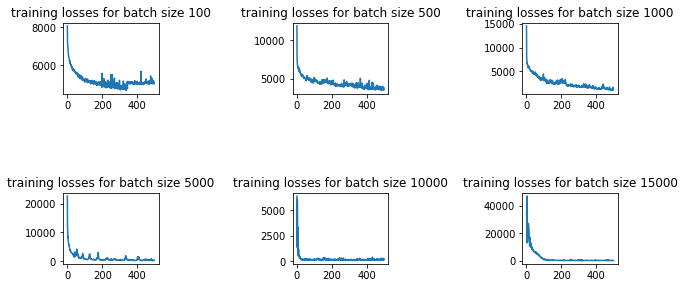

In [ ]:
epochsrange = np.arange(epochs)
plt.figure(figsize=(12, 6))
plt.subplot(4,6,1)
training_losses = np.load("/content/drive/Shareddrives/CIS545 Final Project/DL_model_trainingloss_b100.npy")
plt.plot(epochsrange,training_losses)
plt.title("training losses for batch size 100")
plt.subplot(4,6,3)
training_losses = np.load("/content/drive/Shareddrives/CIS545 Final Project/DL_model_trainingloss_b500.npy")
plt.plot(epochsrange,training_losses)
plt.title("training losses for batch size 500")
plt.subplot(4,6,5)
training_losses = np.load("/content/drive/Shareddrives/CIS545 Final Project/DL_model_trainingloss_b1000.npy")
plt.plot(epochsrange,training_losses)
plt.title("training losses for batch size 1000")
plt.subplot(4,6,13)
training_losses = np.load("/content/drive/Shareddrives/CIS545 Final Project/DL_model_trainingloss_b5000.npy")
plt.plot(epochsrange,training_losses)
plt.title("training losses for batch size 5000")
plt.subplot(4,6,15)
training_losses = np.load("/content/drive/Shareddrives/CIS545 Final Project/DL_model_trainingloss_b10000.npy")
plt.plot(epochsrange,training_losses)
plt.title("training losses for batch size 10000")
plt.subplot(4,6,17)
training_losses = np.load("/content/drive/Shareddrives/CIS545 Final Project/DL_model_trainingloss_b15000.npy")
plt.plot(epochsrange,training_losses)
_ = plt.title("training losses for batch size 15000")


## **16. Discussion on Regression Analysis Results**
In the regression analysis, we used the linear regresssion as baseline, and applied elasticnet and xgboost with & without PCA. Finally we had neural networks to serve as a deep learning perspective for the analysis. The baseline linear regression achieved a RMSE value of 75.70. However, by applying PCA and adjust hyperparameter for the elastic net, we did not get a better results for the RMSE, and even some of the elastic net models did get worse than the baseline model. The XGBoost model actually achieved the best RMSE of 62.3366 without applying PCA, but unfortunately the neural networks did not perform well, and that probably due to that it is more suitable for classification problems.

RMSE summary for each model:
- Baseline Linear Regression: RMSE = 75.699
- Linear Regression with PCA: RMSE = 75.702
- Elasticnet (alpha = 0, l1_ratio = 0): RMSE = 75.699
- Elasticnet with PCA (alpha = 0.01, l1_ratio = 0.9): RMSE = 75.701
- XGBoost: RMSE = 62.3366
- XGBoost with PCA: RMSE = 70.704
- Deep Learning: RMSE = 142.628 ( with Adam optimizer and lr =0.01)

In conclusion it was found that for this task with this set of features, traditional regression methods exhibited better performance than deep learning models with XGBoost boasting the best results.

It may be possible to obtain better results by better feature selection and/or network architecture.

# **PART III Classification on Whether the Airbnb Price is Above Average**
The last part of our final project is using the average price as a bar to divide the price into two categories, which is whether the price is above average or not. In this case, we aimed for a binary classificaiton problem in this section. In this case, we will use the prediction accuracy as the evaluation metrix. The model we used in this part is logistic regerssion as baseline, linear support vector machien, rbf kernal support vector machine (with and without PCA), random forest, and finally deep neural networks. 

##**17. Data Split for Classification**

In [ ]:
# create train and test data for machine learning models
from sklearn.model_selection import train_test_split

train_size = 0.8
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(airbnb_class_feature, airbnb_class_label, test_size=test_size, random_state=42)

## **18. Baseline Logistic Regression for Classification**
The baseline regression model on the above_average label gives us accruacy of 0.771, which we believe is a pretty good accuracy for the baseline model and still have a lot of space for improvement. 


In [ ]:
# set up logistic regression model and train using the airbnb data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [ ]:
# calculate accuracy for the baseline model
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
score

0.7710799267846248

## **19. Principal Component Analysis**
We then applied the principal component analysis and visualized the cumulative expalined ratio for the varinace. By choosing 38 principal component for the logistic regression analysis, we achieved accuracy of 0.824.

In [ ]:
# standardization for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

In [ ]:
# setup PCA for full number of principal component
pca = PCA()
pca_fit = pca.fit(x_train_sc)

In [ ]:
# calculate the cumulative explained ratio
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = []
update = 0
for i in explained_variance_ratios:
  update = update + i
  cum_evr.append(update)

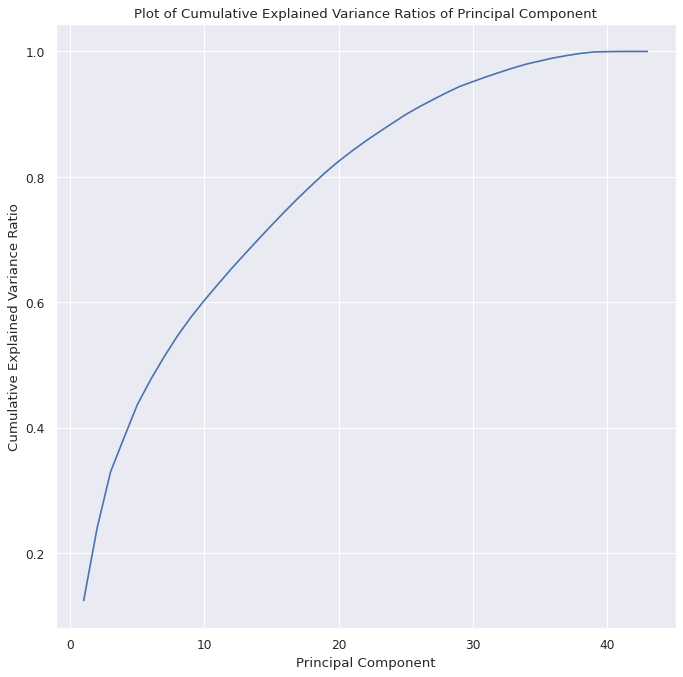

In [ ]:
# plot the cumulative explained ratio
x = len(explained_variance_ratios)
x_axis = [*range(x)]
x_axis = [x+1 for x in x_axis]

plt.figure(figsize=(10, 10), dpi=80)
plt.plot(x_axis, cum_evr)
plt.title("Plot of Cumulative Explained Variance Ratios of Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.show()

In [ ]:
# choose the top 38 principal component
optimal_component_num = 38
pca = PCA(n_components = optimal_component_num)
x_train_pca = pca.fit_transform(x_train_sc)
x_test_pca = pca.transform(x_test_sc)

In [ ]:
# train the logistic regression using the PCA data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(x_train_pca, y_train)
y_pred = clf.predict(x_test_pca)

In [ ]:
# calcualte accuracy score
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
score

0.824039048200122

## **20. Classification: Helper Method**

In [ ]:
# Helper Method for Random Forest
from sklearn.ensemble import RandomForestClassifier
def rf_train(x_train, x_test, y_train, y_test, depth_list, train_accuracy_list, test_accuracy_list, rmse_rf_list):
  for depth in depth_list: 
    #set up the RandomForest Model
    rf = RandomForestClassifier(max_depth= depth)
    #Model Training
    rf.fit(x_train,y_train.values.ravel())
    #Result Prediction
    y_pred = rf.predict(x_test)
    #Training Accuracy
    train_acc = rf.score(x_train, y_train)
    train_accuracy_list.append(train_acc)
    #Test Accuracy
    test_acc = rf.score(x_test, y_test)
    test_accuracy_list.append(test_acc)
    #Calculate Training Accuracy
    rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_rf_list.append(rf_rmse)
    print("Random Forest Depth: %s, train_score: %s, test_score: %s, RMSE: %s" % (depth, train_acc, test_acc,rf_rmse))

## **21. Classification - Random Forest (Without PCA)**

Random Forest is a good choice for doing classifcation problem and our group also decided to conudct a training applying PCA and one without PCA considering the problem appeared in XGBoost. Max Depth is used als the hyperparameter for tuning and we found the best model is with the depth of 12 with the accuracy of 0.848. Overfitting appeared after depth deeper than 12


In [ ]:
#call the Randorm Forest training without PCA
depth_list= range(2, 22, 2);
train_rf_list = []
test_rf_list = []
rmse_rf_list = []
rf_train(x_train,x_test,y_train, y_test, depth_list, train_rf_list, test_rf_list,rmse_rf_list)

Random Forest Depth: 2, train_score: 0.789261744966443, test_score: 0.7810860280658939, RMSE: 0.4678824338806771
Random Forest Depth: 4, train_score: 0.8276998169615619, test_score: 0.8224527150701647, RMSE: 0.421363601809453
Random Forest Depth: 6, train_score: 0.8366381940207444, test_score: 0.8279438682123246, RMSE: 0.4147964944254898
Random Forest Depth: 8, train_score: 0.850274557657108, test_score: 0.8383160463697377, RMSE: 0.40209943251671265
Random Forest Depth: 10, train_score: 0.8708358755338621, test_score: 0.8430750457596096, RMSE: 0.39613754459832573
Random Forest Depth: 12, train_score: 0.9053691275167786, test_score: 0.8475899938987187, RMSE: 0.39039724141095217
Random Forest Depth: 14, train_score: 0.9409395973154362, test_score: 0.8464917632702867, RMSE: 0.3918012719858286
Random Forest Depth: 16, train_score: 0.9697681513117755, test_score: 0.8464917632702867, RMSE: 0.3918012719858286
Random Forest Depth: 18, train_score: 0.9849908480780964, test_score: 0.847712019524

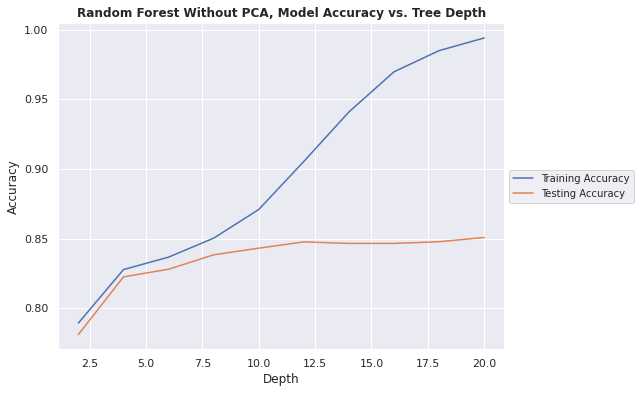

In [ ]:
#Plot the result of the Random Forest Training and Testing Accuracy vs. Tree Depth
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(depth_list,train_rf_list,label='Training Accuracy')
plt.plot(depth_list,test_rf_list,label='Testing Accuracy')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("Random Forest Without PCA, Model Accuracy vs. Tree Depth", weight = 'bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 10)
plt.show()

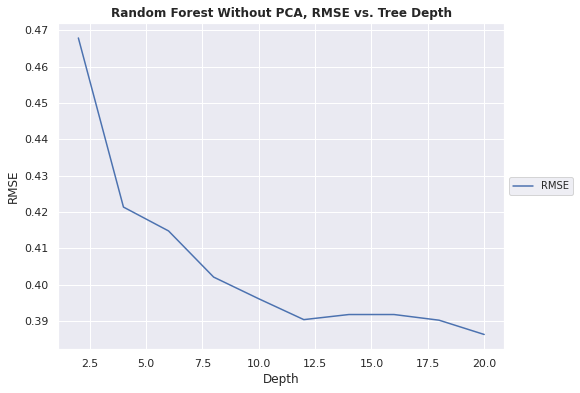

In [ ]:
#Plot the RMSE value for the RandomForest Model without training
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(depth_list,rmse_rf_list,label='RMSE')
plt.xlabel("Depth")
plt.ylabel("RMSE")
plt.title("Random Forest Without PCA, RMSE vs. Tree Depth", weight = 'bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 10)
plt.show()

From the plot and the printed results, the best model is shown below:

1.   RandomForest Depth: 12
2.   Training Accuracy: 0.9053691275167786
3.   Testing Accuracy: 0.8475899938987187


## **22. Classification - Random Forest (With PCA)**



For the training with PCA, we found the best model is with the depth of 12 as well with the accuracy of 0.825. Overfitting appeared after depth deeper than 12, similar to the model without PCA training. The accuracy and performance of the model with PCA are also slight worse than the one without PCA similar to the XGBoost Model in Regression.


In [ ]:
#call the Randorm Forest training with PCA
depth_list= range(2, 22, 2);
train_rf_pca_list = []
test_rf_pca_list = []
rmse_rf_pca_list = []
rf_train(x_train_pca,x_test_pca,y_train, y_test, depth_list, train_rf_pca_list, test_rf_pca_list,rmse_rf_pca_list)

Random Forest Depth: 2, train_score: 0.6825503355704698, test_score: 0.6767541183648567, RMSE: 0.5685471674673469
Random Forest Depth: 4, train_score: 0.7905125076266016, test_score: 0.7773032336790726, RMSE: 0.4719075823939761
Random Forest Depth: 6, train_score: 0.8206833435021355, test_score: 0.7987797437461867, RMSE: 0.44857580881475684
Random Forest Depth: 8, train_score: 0.8466748017083587, test_score: 0.811470408785845, RMSE: 0.4341999438209947
Random Forest Depth: 10, train_score: 0.8831299572910312, test_score: 0.8147651006711409, RMSE: 0.43038924165092585
Random Forest Depth: 12, train_score: 0.9221476510067114, test_score: 0.82477120195241, RMSE: 0.41860338991411666
Random Forest Depth: 14, train_score: 0.9567114093959731, test_score: 0.8263575350823673, RMSE: 0.41670428953591626
Random Forest Depth: 16, train_score: 0.975503355704698, test_score: 0.82477120195241, RMSE: 0.41860338991411666
Random Forest Depth: 18, train_score: 0.9868517388651616, test_score: 0.8257474069554

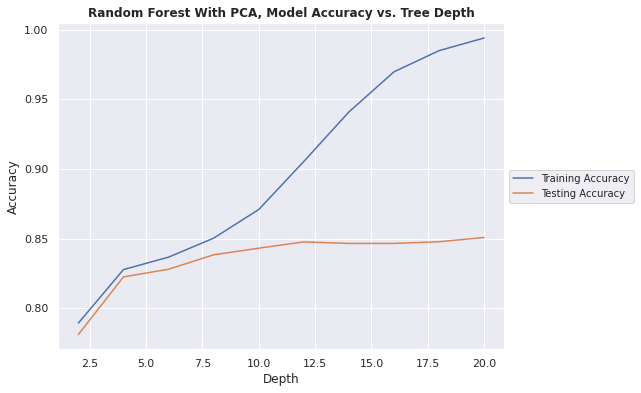

In [ ]:
#Plot the result of the Random Forest Training and Testing Accuracy vs. Tree Depth
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(depth_list,train_rf_list,label='Training Accuracy')
plt.plot(depth_list,test_rf_list,label='Testing Accuracy')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("Random Forest With PCA, Model Accuracy vs. Tree Depth", weight = 'bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 10)
plt.show()

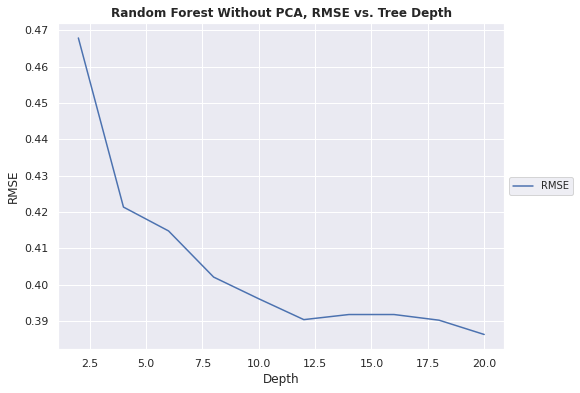

In [ ]:
#Plot the RMSE value for the RandomForest Model without training
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(depth_list,rmse_rf_list,label='RMSE')
plt.xlabel("Depth")
plt.ylabel("RMSE")
plt.title("Random Forest Without PCA, RMSE vs. Tree Depth", weight = 'bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 10)
plt.show()

From the plot and the printed results, the best model is shown below:

1.   RandomForest Depth: 12
2.   Training Accuracy: 0.9221476510067114
3.   Testing Accuracy: 0.82477120195241

## **23. Classification - Support Vector Machine (Without PCA)**
In order to discover and compare linear model versus non-linear model, in the following part we performed support vector machien using linear kernel as well as a rbf kernel. From the results we can clearly see that the linear SVM outcompete the rbf SVM with accuracy of 0.810 and 0.702 respectively.

### 23.1 Linear SVM

In [ ]:
# set up linear SVM
from sklearn import svm
clf = svm.SVC(kernel = 'linear')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# cauculate accuracy for svm
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
score

0.810006101281269

### 23.2 RBF SVM

In [ ]:
# set up rbf SVM
from sklearn import svm
clf = svm.SVC(kernel = 'rbf')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# cauculate accuracy for svm
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
score

0.7018913971934106

## **24. Classificaiton - Support Vector Machine (With PCA)**
In this section, we used the PCA data from the previous section for training the SVM, and in this part, we got an intersting results that the RBF SVM is better with an accuracy of 0.835, but the linear SVM only has 0.822. This results leads to the conclusion that after applying the PCA to the original data, the data changed from linear to non-linear.

### 24.1 Linear SVM

In [ ]:
# set up linear svm
from sklearn import svm
clf = svm.SVC(kernel = 'linear')
clf.fit(x_train_pca, y_train)
y_pred = clf.predict(x_test_pca)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# cauculate accuracy for svm
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
score

0.8224527150701647

### 24.2 RBF SVM

In [ ]:
# set up rbf svm
from sklearn import svm
clf = svm.SVC(kernel = 'rbf')
clf.fit(x_train_pca, y_train)
y_pred = clf.predict(x_test_pca)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# cauculate accuracy for svm
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
score

0.8353874313605857

## **25. Deep Learning**


A 5 layer layer linear model was used for the classification task with a sigmoid activation layer being used with the output layer and a Binary cross entropy loss function. An Adam optimizer was used with an 80/20 train test split.

###utils

In [41]:
#Package import
import torch
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import requests
import io
from urllib.request import urlopen
import pandas as pd
import sklearn.model_selection as sk

In [42]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

#normalizing elements    
def normalize(x):
    x_normed = x / x.max(0)[0]
    return x_normed

In [43]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y


    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

###Classification Model



In [53]:
class ClassNet(nn.Module):
    def __init__(self):
        super(ClassNet, self).__init__()
        # x = 4096
        self.fc = nn.Sequential(nn.Linear(42,128),
                                nn.ReLU(),
                                nn.Linear(128, 256),
                                nn.ReLU(),
                                nn.Linear(256,512),
                                nn.ReLU(),
                                nn.Linear(512, 1024),
                                nn.ReLU(),
                                nn.Linear(1024, 1),
                                nn.Sigmoid()
                                )
        

    def forward(self, x):
        output = self.fc(x)
        return output

In [45]:
def train(model, device, train_loader, optimizer, epochs=100,batch_size=50):
  training_losses = []
  train_loader.to(device)
  for epoch in range(epochs):
      epoch_loss = 0
      for i in range(int(train_loader.shape[0]/batch_size)-1):
          model.train()
          data = train_loader[i*50:(i+1)*50,:-1]
          target = train_loader[i*50:(i+1)*50,-1]
          output = model(data)
          # print('output:')
          # print('target:',target.shape)
          output = torch.squeeze(output)
          # print(output)
          # output = output.cpu().detach().numpy()
          loss = F.binary_cross_entropy(output,target)
          # print(loss)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_loss+=float(loss.data)    
      epoch_loss=(epoch_loss/((train_loader.shape[0]/batch_size)-1))    
      training_losses.append(epoch_loss)   
      if(epoch%10==0):   
          print("epoch:",epoch," average training BCE loss:",epoch_loss) 

  return epoch_loss,np.array(training_losses)      
        

def test(model, device, test_loader):
    #sets model in eval mode
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        data = test_loader[:,:-1]
        target = test_loader[:,-1]
        output = model(data)
        test_loss += F.binary_cross_entropy(torch.squeeze(output), target, reduction='sum').item()  # sum up batch loss
        pred = output.cpu().detach().numpy()
        pred[pred>=0.5] = 1
        pred[pred<0.5] =0
        pred = torch.tensor(pred).to(device)
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader),
        100. * correct / len(test_loader)))
    return 100. * correct / len(test_loader)   

In [46]:
train_size = 0.8
test_size = 0.2

In [47]:
trainloader = df_to_tensor(airbnb_class_feature)
trainloader = normalize(trainloader)
trainloader = torch.cat((trainloader,df_to_tensor(airbnb_class_label)),dim=1)
device = get_device()
X_train, X_test, y_train, y_test = sk.train_test_split(trainloader[:,:-1],trainloader[:,-1],test_size=test_size, random_state = 42)
y_train,y_test = torch.unsqueeze(y_train,dim=1),torch.unsqueeze(y_test,dim=1)
trainloader = torch.cat((X_train,y_train),dim=1)
testloader = torch.cat((X_test,y_test),dim=1)

In [54]:
Class_model = ClassNet()
Class_model.to(device)

ClassNet(
  (fc): Sequential(
    (0): Linear(in_features=42, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [55]:
epochs = 100
batch_size=100
optimizer = torch.optim.Adam(Class_model.parameters(),lr=0.01,betas=(0.9,0.999),eps=1e-08,weight_decay=0)
# optimizer = torch.optim.SGD(Reg_model.parameters(),lr=0.05)
loss,training_losses = train(Class_model,device,trainloader,optimizer,epochs,batch_size)
print("final Avg loss is",loss)

epoch: 0  average training BCE loss: 0.4776626728666602
epoch: 10  average training BCE loss: 0.3956086928597133
epoch: 20  average training BCE loss: 0.3824395280117066
epoch: 30  average training BCE loss: 0.3762058941522018
epoch: 40  average training BCE loss: 0.3741050637902799
epoch: 50  average training BCE loss: 0.3726990698783167
epoch: 60  average training BCE loss: 0.36963277928430854
epoch: 70  average training BCE loss: 0.36664267885641194
epoch: 80  average training BCE loss: 0.364529240507099
epoch: 90  average training BCE loss: 0.3644007945950787
final Avg loss is 0.36423332168466455


In [56]:
accuracy = test(Class_model,device,testloader)


Test set: Average loss: 0.3853, Accuracy: 6751/8195 (82.3795%)



## **26. Discussion on Classification Analysis Results**

In this classification analysis, we actually got better resutls than the regression analysis. The baseline model using logistic regression has relatively lower accuracy, and the random forest and support vector machine offered a higher accuracy. In addition, for the support vector machien analysis, we can find that by using the original data, the linear SVM has a better performance, while by changing to the PCA data, the RBF SVM got a better accuracy. This would disclose the transformation of the data from linear to non-linear and finally in the SVM model the version using PCA and RBF SVM actually got the highest score. With the PCA on random forest reduced its accuracy, the random forest without PCA actually performed better than baseline and SVM, and got an accuracy of 0.851 for testing set. In this task deep learning models performed about on par with random forest based models with an accuracy of 0.823.

Accuracy summary for each of the mode:
- Baseline logistic regression: Accuracy = 0.771
- Logistic regression with PCA: Accuracy = 0.824
- Random Forest: Accuracy = 0.848
- Random Foest with PCA: Accuracy = 0.825
- Linear SVM: Accuracy = 0.810
- RBF SVM: Accuracy = 0.702
- Linear SVM with PCA: Accuracy = 0.822
- RBF SVM with PCA: Accuracy = 0.835
- Deep learning: Accuracy = 0.823

##**27. Moving Forward**
Even though the classification model works well , but still the regression price prediction is not perfect. To reach our goal of providing a useful and reliable tool for both the hosts and users to estimate the price of Airbnb in NYC, our group decides to move forward to improve our model by introducing more features and more advanced model when we have access to more robust resources. Some potential movements are listed below:
1.	Adopting tokenized description,  amenities, and even reviews into training model 

2.	Tunning the model including more hyperparameters 

3.	Adding stream query to update the model with the latest market data.
